In [1]:
!pip install -q focal-loss torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.1 MB/s eta 0:00:00



Class Distribution Analysis
Class 0 (Healthy): 17 samples (30.91%)
Class 1 (Diseased): 38 samples (69.09%)
Imbalance Ratio: 2.24:1


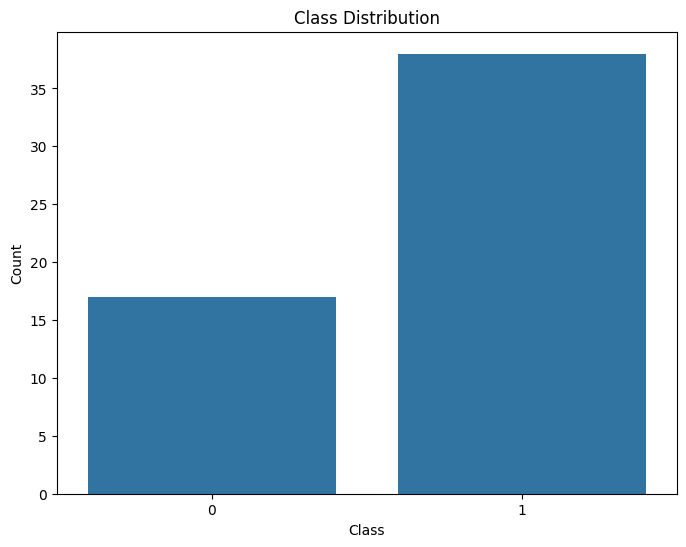


Fat Percentage Distribution Analysis
Min Fat: 0.00%
Max Fat: 85.00%
Mean Fat: 27.25%
Median Fat: 20.00%

Fat Distribution by Class:
Class 0 (Healthy): Min=0.00%, Max=4.00%, Mean=1.88%
Class 1 (Diseased): Min=5.00%, Max=85.00%, Mean=38.61%


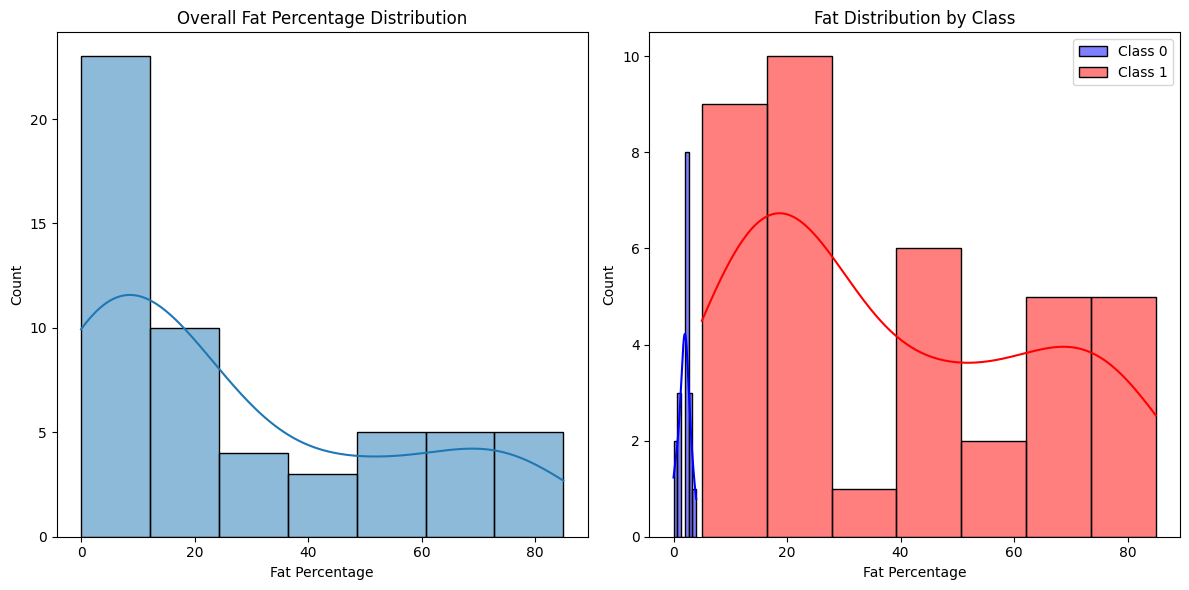


Samples with fat > 90%: 0 (0.00%)


In [2]:
import scipy.io as sio
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, LambdaLR
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score, confusion_matrix, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os
import time
import math
from torch.cuda.amp import GradScaler, autocast
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from timm.layers import DropPath

# Create directory for saving results
timestamp = time.strftime("%Y%m%d_%H%M%S")
results_dir = f'results_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# 1. Enhanced Data Loading with Stratified Splitting
MAT_PATH = '/content/dataset_liver_bmodes_steatosis_assessment_IJCARS.mat'
mat = sio.loadmat(MAT_PATH)
data_all = mat['data']

all_vols, all_classes, all_fats = [], [], []
for j in range(data_all.shape[1]):
    ds = data_all[0, j]
    all_vols.append(ds['images'])
    all_classes.append(int(ds['class'].squeeze()))
    all_fats.append(float(ds['fat'].squeeze()))

all_vols = np.stack(all_vols, axis=0)
all_classes = np.array(all_classes)
all_fats = np.array(all_fats, dtype=np.float32)

# ========================================================================
# Data Analysis Section
# ========================================================================

def analyze_class_distribution(classes):
    class_counts = np.bincount(classes)
    total = len(classes)
    print("\n" + "="*50)
    print("Class Distribution Analysis")
    print("="*50)
    print(f"Class 0 (Healthy): {class_counts[0]} samples ({class_counts[0]/total*100:.2f}%)")
    print(f"Class 1 (Diseased): {class_counts[1]} samples ({class_counts[1]/total*100:.2f}%)")
    print(f"Imbalance Ratio: {class_counts[1]/class_counts[0]:.2f}:1")

    # Visualize distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=classes)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.savefig(os.path.join(results_dir, 'class_distribution.png'))
    plt.show()
    return class_counts

def analyze_fat_distribution(fats, classes):
    print("\n" + "="*50)
    print("Fat Percentage Distribution Analysis")
    print("="*50)

    # Basic statistics
    print(f"Min Fat: {fats.min():.2f}%")
    print(f"Max Fat: {fats.max():.2f}%")
    print(f"Mean Fat: {fats.mean():.2f}%")
    print(f"Median Fat: {np.median(fats):.2f}%")

    # Distribution by class
    class_0_fats = fats[classes == 0]
    class_1_fats = fats[classes == 1]

    print("\nFat Distribution by Class:")
    print(f"Class 0 (Healthy): Min={class_0_fats.min():.2f}%, Max={class_0_fats.max():.2f}%, "
          f"Mean={class_0_fats.mean():.2f}%")
    print(f"Class 1 (Diseased): Min={class_1_fats.min():.2f}%, Max={class_1_fats.max():.2f}%, "
          f"Mean={class_1_fats.mean():.2f}%")

    # Visualize distribution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(fats, kde=True)
    plt.title("Overall Fat Percentage Distribution")
    plt.xlabel("Fat Percentage")

    plt.subplot(1, 2, 2)
    sns.histplot(class_0_fats, color='blue', label='Class 0', kde=True, alpha=0.5)
    sns.histplot(class_1_fats, color='red', label='Class 1', kde=True, alpha=0.5)
    plt.title("Fat Distribution by Class")
    plt.xlabel("Fat Percentage")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'fat_distribution.png'))
    plt.show()

    # Check for values near 100%
    near_100 = fats[fats > 90]
    print(f"\nSamples with fat > 90%: {len(near_100)} ({len(near_100)/len(fats)*100:.2f}%)")

    return fats.min(), fats.max()

# Run analysis
class_counts = analyze_class_distribution(all_classes)
fat_min, fat_max = analyze_fat_distribution(all_fats, all_classes)


Using device: cuda

Starting Training for Fold 0


<ipython-input-8-3051131134>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),
<ipython-input-8-3051131134>:60: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),


Fold 0: Train samples: 35, Val samples: 9
Class distribution - Train: [11 24], Val: [3 6]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-3051131134>:546: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args

EarlyStopping counter: 0/10, best min: 0.3483
Epoch 1/100
Train Loss: 0.1792 (Cls: 0.1016, Reg: 0.1109)
Val Loss: 0.3483 (Cls: 0.1541, Reg: 0.2774)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 51.7923 | Val R2: -4.2553 | LR: 4.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.1247
Epoch 2/100
Train Loss: 0.1557 (Cls: 0.0901, Reg: 0.0938)
Val Loss: 0.1247 (Cls: 0.1004, Reg: 0.0347)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 16.2744 | Val R2: 0.3112 | LR: 6.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.1247
Epoch 3/100
Train Loss: 0.2693 (Cls: 0.1430, Reg: 0.1804)
Val Loss: 0.3162 (Cls: 0.1826, Reg: 0.1908)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 41.6678 | Val R2: -2.4066 | LR: 7.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.1247
Epoch 4/100
Train Loss: 0.2433 (Cls: 0.1489, Reg: 0.1348)
Val Loss: 0.1723 (Cls: 0.1416, Reg: 0.0438)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 18.0033 | Val R2: 0.2852 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0995
Epoch 5/100
Train Loss: 0.2310 (Cls: 0.1541, Reg: 0.1098)
Val Loss: 0.0995 (Cls: 0.0752, Reg: 0.0347)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 17.4045 | Val R2: 0.3532 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0849
Epoch 6/100
Train Loss: 0.2119 (Cls: 0.1432, Reg: 0.0982)
Val Loss: 0.0849 (Cls: 0.0460, Reg: 0.0555)
Val Acc: 0.6667 | Val F1: 0.6667 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 22.0484 | Val R2: 0.0669 | LR: 9.95e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0849
Epoch 7/100
Train Loss: 0.1634 (Cls: 0.0857, Reg: 0.1109)
Val Loss: 0.1710 (Cls: 0.1287, Reg: 0.0605)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 23.0533 | Val R2: -0.0640 | LR: 9.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0614
Epoch 8/100
Train Loss: 0.2216 (Cls: 0.1407, Reg: 0.1156)
Val Loss: 0.0614 (Cls: 0.0416, Reg: 0.0283)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 15.7646 | Val R2: 0.5142 | LR: 9.88e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0614
Epoch 9/100
Train Loss: 0.1674 (Cls: 0.0993, Reg: 0.0973)
Val Loss: 0.0826 (Cls: 0.0405, Reg: 0.0601)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 23.0606 | Val R2: -0.0445 | LR: 9.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0614
Epoch 10/100
Train Loss: 0.1366 (Cls: 0.0855, Reg: 0.0730)
Val Loss: 0.0646 (Cls: 0.0403, Reg: 0.0348)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 16.6815 | Val R2: 0.4800 | LR: 9.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0560
Epoch 11/100
Train Loss: 0.1480 (Cls: 0.0731, Reg: 0.1070)
Val Loss: 0.0560 (Cls: 0.0372, Reg: 0.0268)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 14.5494 | Val R2: 0.5858 | LR: 9.74e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0560
Epoch 12/100
Train Loss: 0.1040 (Cls: 0.0495, Reg: 0.0778)
Val Loss: 0.0598 (Cls: 0.0349, Reg: 0.0356)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 17.2146 | Val R2: 0.4069 | LR: 9.69e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0560
Epoch 13/100
Train Loss: 0.1602 (Cls: 0.1016, Reg: 0.0837)
Val Loss: 0.0666 (Cls: 0.0322, Reg: 0.0492)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 20.7999 | Val R2: 0.1400 | LR: 9.63e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0434
Epoch 14/100
Train Loss: 0.1272 (Cls: 0.0551, Reg: 0.1029)
Val Loss: 0.0434 (Cls: 0.0334, Reg: 0.0143)
Val Acc: 0.6667 | Val F1: 0.6667 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 12.5853 | Val R2: 0.6050 | LR: 9.56e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0434
Epoch 15/100
Train Loss: 0.1334 (Cls: 0.0851, Reg: 0.0689)
Val Loss: 0.1491 (Cls: 0.0348, Reg: 0.1633)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 41.1799 | Val R2: -2.1679 | LR: 9.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0434
Epoch 16/100
Train Loss: 0.1224 (Cls: 0.0541, Reg: 0.0977)
Val Loss: 0.0694 (Cls: 0.0591, Reg: 0.0146)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 11.3621 | Val R2: 0.5748 | LR: 9.42e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0434
Epoch 17/100
Train Loss: 0.1440 (Cls: 0.0800, Reg: 0.0915)
Val Loss: 0.0669 (Cls: 0.0529, Reg: 0.0200)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 13.0510 | Val R2: 0.6201 | LR: 9.34e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0434
Epoch 18/100
Train Loss: 0.0937 (Cls: 0.0452, Reg: 0.0694)
Val Loss: 0.0617 (Cls: 0.0274, Reg: 0.0490)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 20.2775 | Val R2: 0.1961 | LR: 9.26e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0434
Epoch 19/100
Train Loss: 0.0929 (Cls: 0.0477, Reg: 0.0645)
Val Loss: 0.0683 (Cls: 0.0566, Reg: 0.0168)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 15.9681 | Val R2: 0.2832 | LR: 9.17e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0434
Epoch 20/100
Train Loss: 0.1170 (Cls: 0.0667, Reg: 0.0720)
Val Loss: 0.0617 (Cls: 0.0500, Reg: 0.0167)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 16.2267 | Val R2: 0.2833 | LR: 4.54e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0360
Epoch 21/100
Train Loss: 0.1345 (Cls: 0.0874, Reg: 0.0674)
Val Loss: 0.0360 (Cls: 0.0287, Reg: 0.0104)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 12.1683 | Val R2: 0.6743 | LR: 4.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0247
Epoch 22/100
Train Loss: 0.0849 (Cls: 0.0574, Reg: 0.0393)
Val Loss: 0.0247 (Cls: 0.0208, Reg: 0.0056)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 10.1149 | Val R2: 0.7660 | LR: 4.44e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0247
Epoch 23/100
Train Loss: 0.0959 (Cls: 0.0564, Reg: 0.0564)
Val Loss: 0.0431 (Cls: 0.0391, Reg: 0.0057)
Val Acc: 0.4444 | Val F1: 0.3723 | Val Precision: 1.0000 | Val Recall: 0.1667
Val MAE: 9.9072 | Val R2: 0.7744 | LR: 4.39e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0247
Epoch 24/100
Train Loss: 0.1177 (Cls: 0.0733, Reg: 0.0635)
Val Loss: 0.0290 (Cls: 0.0252, Reg: 0.0055)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.1896 | Val R2: 0.7755 | LR: 4.34e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0208
Epoch 25/100
Train Loss: 0.0762 (Cls: 0.0359, Reg: 0.0576)
Val Loss: 0.0208 (Cls: 0.0167, Reg: 0.0059)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.5717 | Val R2: 0.7729 | LR: 4.28e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0203
Epoch 26/100
Train Loss: 0.1183 (Cls: 0.0708, Reg: 0.0678)
Val Loss: 0.0203 (Cls: 0.0160, Reg: 0.0061)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.4294 | Val R2: 0.7801 | LR: 4.23e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0203
Epoch 27/100
Train Loss: 0.0711 (Cls: 0.0303, Reg: 0.0583)
Val Loss: 0.0211 (Cls: 0.0170, Reg: 0.0059)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.6976 | Val R2: 0.7650 | LR: 4.17e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0203
Epoch 28/100
Train Loss: 0.0623 (Cls: 0.0358, Reg: 0.0378)
Val Loss: 0.0226 (Cls: 0.0182, Reg: 0.0063)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 11.0767 | Val R2: 0.7664 | LR: 4.11e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0203
Epoch 29/100
Train Loss: 0.0937 (Cls: 0.0466, Reg: 0.0673)
Val Loss: 0.0289 (Cls: 0.0210, Reg: 0.0113)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 13.4792 | Val R2: 0.5594 | LR: 4.05e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0203
Epoch 30/100
Train Loss: 0.0606 (Cls: 0.0250, Reg: 0.0508)
Val Loss: 0.0253 (Cls: 0.0216, Reg: 0.0054)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.1576 | Val R2: 0.7724 | LR: 3.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0203
Epoch 31/100
Train Loss: 0.0853 (Cls: 0.0470, Reg: 0.0547)
Val Loss: 0.0221 (Cls: 0.0169, Reg: 0.0073)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 10.0856 | Val R2: 0.7628 | LR: 3.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0203
Epoch 32/100
Train Loss: 0.0642 (Cls: 0.0353, Reg: 0.0412)
Val Loss: 0.0206 (Cls: 0.0167, Reg: 0.0055)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 9.7993 | Val R2: 0.7791 | LR: 1.93e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0203
Epoch 33/100
Train Loss: 0.0898 (Cls: 0.0411, Reg: 0.0697)
Val Loss: 0.0244 (Cls: 0.0181, Reg: 0.0090)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 12.4698 | Val R2: 0.6615 | LR: 1.89e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0203
Epoch 34/100
Train Loss: 0.0907 (Cls: 0.0589, Reg: 0.0454)
Val Loss: 0.0246 (Cls: 0.0164, Reg: 0.0118)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 13.6576 | Val R2: 0.5922 | LR: 1.86e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0203
Epoch 35/100
Train Loss: 0.0615 (Cls: 0.0415, Reg: 0.0286)
Val Loss: 0.0218 (Cls: 0.0136, Reg: 0.0117)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 13.6766 | Val R2: 0.5831 | LR: 1.82e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0191
Epoch 36/100
Train Loss: 0.0766 (Cls: 0.0348, Reg: 0.0597)
Val Loss: 0.0191 (Cls: 0.0153, Reg: 0.0054)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 9.7319 | Val R2: 0.7713 | LR: 1.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0191
Epoch 37/100
Train Loss: 0.0707 (Cls: 0.0468, Reg: 0.0341)
Val Loss: 0.0252 (Cls: 0.0198, Reg: 0.0078)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 9.7193 | Val R2: 0.7577 | LR: 1.75e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0191
Epoch 38/100
Train Loss: 0.0721 (Cls: 0.0372, Reg: 0.0498)
Val Loss: 0.0259 (Cls: 0.0206, Reg: 0.0076)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 9.5367 | Val R2: 0.7637 | LR: 1.72e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0191
Epoch 39/100
Train Loss: 0.0795 (Cls: 0.0405, Reg: 0.0558)
Val Loss: 0.0212 (Cls: 0.0169, Reg: 0.0061)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 9.6935 | Val R2: 0.7836 | LR: 1.68e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0161
Epoch 40/100
Train Loss: 0.0607 (Cls: 0.0283, Reg: 0.0463)
Val Loss: 0.0161 (Cls: 0.0116, Reg: 0.0064)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 11.2486 | Val R2: 0.7315 | LR: 1.64e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0156
Epoch 41/100
Train Loss: 0.0710 (Cls: 0.0354, Reg: 0.0508)
Val Loss: 0.0156 (Cls: 0.0110, Reg: 0.0065)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 11.3322 | Val R2: 0.7271 | LR: 1.61e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0142
Epoch 42/100
Train Loss: 0.0612 (Cls: 0.0428, Reg: 0.0262)
Val Loss: 0.0142 (Cls: 0.0101, Reg: 0.0059)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 10.6002 | Val R2: 0.7606 | LR: 1.57e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0135
Epoch 43/100
Train Loss: 0.0545 (Cls: 0.0297, Reg: 0.0355)
Val Loss: 0.0135 (Cls: 0.0097, Reg: 0.0055)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.6595 | Val R2: 0.7922 | LR: 1.53e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0135
Epoch 44/100
Train Loss: 0.0418 (Cls: 0.0228, Reg: 0.0272)
Val Loss: 0.0141 (Cls: 0.0102, Reg: 0.0055)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.0799 | Val R2: 0.8129 | LR: 1.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0135
Epoch 45/100
Train Loss: 0.0505 (Cls: 0.0334, Reg: 0.0245)
Val Loss: 0.0140 (Cls: 0.0105, Reg: 0.0050)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 8.8436 | Val R2: 0.8246 | LR: 1.45e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0135
Epoch 46/100
Train Loss: 0.0514 (Cls: 0.0210, Reg: 0.0433)
Val Loss: 0.0136 (Cls: 0.0105, Reg: 0.0044)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 8.8413 | Val R2: 0.8179 | LR: 1.41e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0120
Epoch 47/100
Train Loss: 0.0780 (Cls: 0.0630, Reg: 0.0215)
Val Loss: 0.0120 (Cls: 0.0090, Reg: 0.0044)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.7028 | Val R2: 0.8316 | LR: 1.37e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0116
Epoch 48/100
Train Loss: 0.0554 (Cls: 0.0369, Reg: 0.0263)
Val Loss: 0.0116 (Cls: 0.0081, Reg: 0.0051)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.0879 | Val R2: 0.8236 | LR: 1.33e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0116
Epoch 49/100
Train Loss: 0.0493 (Cls: 0.0229, Reg: 0.0377)
Val Loss: 0.0116 (Cls: 0.0078, Reg: 0.0054)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.2018 | Val R2: 0.8221 | LR: 1.29e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0110
Epoch 50/100
Train Loss: 0.0687 (Cls: 0.0368, Reg: 0.0455)
Val Loss: 0.0110 (Cls: 0.0076, Reg: 0.0048)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.0390 | Val R2: 0.8262 | LR: 1.25e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0110
Epoch 51/100
Train Loss: 0.0383 (Cls: 0.0206, Reg: 0.0253)
Val Loss: 0.0133 (Cls: 0.0096, Reg: 0.0054)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 9.4334 | Val R2: 0.7793 | LR: 1.22e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0110
Epoch 52/100
Train Loss: 0.0575 (Cls: 0.0224, Reg: 0.0501)
Val Loss: 0.0144 (Cls: 0.0103, Reg: 0.0059)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 9.7318 | Val R2: 0.7519 | LR: 1.18e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0110
Epoch 53/100
Train Loss: 0.0494 (Cls: 0.0244, Reg: 0.0357)
Val Loss: 0.0138 (Cls: 0.0102, Reg: 0.0051)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 9.1436 | Val R2: 0.7893 | LR: 1.14e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0110
Epoch 54/100
Train Loss: 0.1088 (Cls: 0.0781, Reg: 0.0439)
Val Loss: 0.0116 (Cls: 0.0086, Reg: 0.0043)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.5841 | Val R2: 0.8353 | LR: 1.10e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0110
Epoch 55/100
Train Loss: 0.0567 (Cls: 0.0389, Reg: 0.0255)
Val Loss: 0.0112 (Cls: 0.0079, Reg: 0.0047)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.1995 | Val R2: 0.8450 | LR: 1.06e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0109
Epoch 56/100
Train Loss: 0.0908 (Cls: 0.0547, Reg: 0.0516)
Val Loss: 0.0109 (Cls: 0.0082, Reg: 0.0040)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.2106 | Val R2: 0.8512 | LR: 1.02e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0107
Epoch 57/100
Train Loss: 0.0661 (Cls: 0.0318, Reg: 0.0491)
Val Loss: 0.0107 (Cls: 0.0078, Reg: 0.0041)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.6202 | Val R2: 0.8291 | LR: 9.81e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0107
Epoch 58/100
Train Loss: 0.0685 (Cls: 0.0416, Reg: 0.0385)
Val Loss: 0.0107 (Cls: 0.0075, Reg: 0.0045)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 8.8747 | Val R2: 0.8102 | LR: 9.43e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0107
Epoch 59/100
Train Loss: 0.0578 (Cls: 0.0366, Reg: 0.0302)
Val Loss: 0.0111 (Cls: 0.0074, Reg: 0.0052)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.1480 | Val R2: 0.7828 | LR: 9.05e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0107
Epoch 60/100
Train Loss: 0.0649 (Cls: 0.0224, Reg: 0.0607)
Val Loss: 0.0122 (Cls: 0.0082, Reg: 0.0057)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.4680 | Val R2: 0.7602 | LR: 8.67e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0107
Epoch 61/100
Train Loss: 0.0606 (Cls: 0.0321, Reg: 0.0407)
Val Loss: 0.0154 (Cls: 0.0094, Reg: 0.0086)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 11.2773 | Val R2: 0.6497 | LR: 8.30e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0107
Epoch 62/100
Train Loss: 0.0491 (Cls: 0.0244, Reg: 0.0352)
Val Loss: 0.0166 (Cls: 0.0101, Reg: 0.0092)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 11.6508 | Val R2: 0.6223 | LR: 7.93e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0107
Epoch 63/100
Train Loss: 0.0709 (Cls: 0.0406, Reg: 0.0432)
Val Loss: 0.0155 (Cls: 0.0101, Reg: 0.0078)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 10.8776 | Val R2: 0.6724 | LR: 3.78e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0107
Epoch 64/100
Train Loss: 0.0437 (Cls: 0.0306, Reg: 0.0186)
Val Loss: 0.0141 (Cls: 0.0094, Reg: 0.0067)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 10.2498 | Val R2: 0.7166 | LR: 3.60e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0107
Epoch 65/100
Train Loss: 0.0560 (Cls: 0.0197, Reg: 0.0519)
Val Loss: 0.0127 (Cls: 0.0086, Reg: 0.0059)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.8678 | Val R2: 0.7528 | LR: 3.43e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0107
Epoch 66/100
Train Loss: 0.0581 (Cls: 0.0237, Reg: 0.0490)
Val Loss: 0.0120 (Cls: 0.0081, Reg: 0.0056)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 9.6662 | Val R2: 0.7709 | LR: 3.25e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 10/10, best min: 0.0107
Early stopping triggered.

Confusion Matrix for Fold 0:


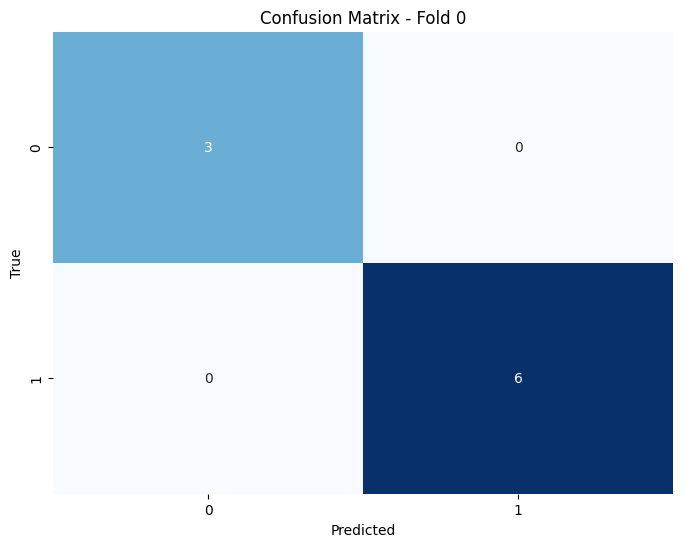

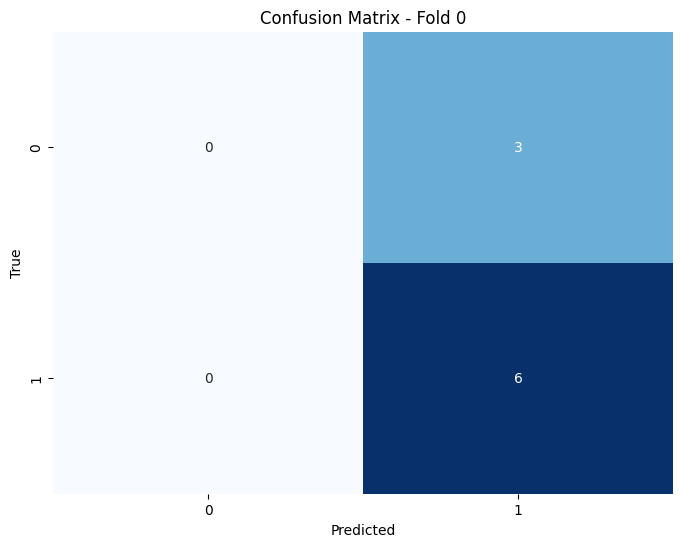


Fold 0 Test Results:
Accuracy: 0.6667
F1-Score (weighted): 0.5333
Precision: 0.6667
Recall (Sensitivity): 1.0000
MAE: 27.5678
R2: -0.4443
Best Epoch: 57

Starting Training for Fold 1
Fold 1: Train samples: 35, Val samples: 9
Class distribution - Train: [11 24], Val: [3 6]


<ipython-input-8-3051131134>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),
<ipython-input-8-3051131134>:60: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-3051131134>:546: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` bef

EarlyStopping counter: 0/10, best min: 0.2314
Epoch 1/100
Train Loss: 0.2253 (Cls: 0.1491, Reg: 0.1089)
Val Loss: 0.2314 (Cls: 0.1219, Reg: 0.1564)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 33.1677 | Val R2: -0.4387 | LR: 4.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.2123
Epoch 2/100
Train Loss: 0.1779 (Cls: 0.0953, Reg: 0.1180)
Val Loss: 0.2123 (Cls: 0.0928, Reg: 0.1707)
Val Acc: 0.4444 | Val F1: 0.3723 | Val Precision: 1.0000 | Val Recall: 0.1667
Val MAE: 32.6933 | Val R2: -0.5686 | LR: 6.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.1681
Epoch 3/100
Train Loss: 0.1565 (Cls: 0.0916, Reg: 0.0927)
Val Loss: 0.1681 (Cls: 0.0739, Reg: 0.1345)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 30.4287 | Val R2: -0.3027 | LR: 7.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.1177
Epoch 4/100
Train Loss: 0.1455 (Cls: 0.0778, Reg: 0.0967)
Val Loss: 0.1177 (Cls: 0.0486, Reg: 0.0988)
Val Acc: 0.6667 | Val F1: 0.6462 | Val Precision: 0.7143 | Val Recall: 0.8333
Val MAE: 28.4080 | Val R2: -0.0043 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.1018
Epoch 5/100
Train Loss: 0.1281 (Cls: 0.0583, Reg: 0.0997)
Val Loss: 0.1018 (Cls: 0.0578, Reg: 0.0628)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 27.1254 | Val R2: 0.1928 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.1018
Epoch 6/100
Train Loss: 0.2111 (Cls: 0.1613, Reg: 0.0712)
Val Loss: 0.1488 (Cls: 0.0891, Reg: 0.0853)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 27.5887 | Val R2: 0.0969 | LR: 9.95e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0664
Epoch 7/100
Train Loss: 0.1433 (Cls: 0.1176, Reg: 0.0367)
Val Loss: 0.0664 (Cls: 0.0306, Reg: 0.0512)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 27.6004 | Val R2: 0.1688 | LR: 9.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0664
Epoch 8/100
Train Loss: 0.1592 (Cls: 0.0864, Reg: 0.1040)
Val Loss: 0.1181 (Cls: 0.0496, Reg: 0.0978)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 27.1152 | Val R2: -0.0399 | LR: 9.88e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0664
Epoch 9/100
Train Loss: 0.1771 (Cls: 0.1222, Reg: 0.0784)
Val Loss: 0.0988 (Cls: 0.0302, Reg: 0.0980)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 26.9855 | Val R2: -0.0521 | LR: 9.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0661
Epoch 10/100
Train Loss: 0.1608 (Cls: 0.0972, Reg: 0.0909)
Val Loss: 0.0661 (Cls: 0.0275, Reg: 0.0552)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 25.2962 | Val R2: 0.2709 | LR: 9.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0661
Epoch 11/100
Train Loss: 0.1080 (Cls: 0.0645, Reg: 0.0622)
Val Loss: 0.1210 (Cls: 0.0451, Reg: 0.1085)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 27.9856 | Val R2: -0.2215 | LR: 9.74e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0661
Epoch 12/100
Train Loss: 0.1843 (Cls: 0.1354, Reg: 0.0698)
Val Loss: 0.0869 (Cls: 0.0247, Reg: 0.0888)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 27.0462 | Val R2: -0.0122 | LR: 9.69e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0495
Epoch 13/100
Train Loss: 0.1289 (Cls: 0.0730, Reg: 0.0798)
Val Loss: 0.0495 (Cls: 0.0212, Reg: 0.0405)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 23.7455 | Val R2: 0.3560 | LR: 9.63e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0495
Epoch 14/100
Train Loss: 0.1062 (Cls: 0.0791, Reg: 0.0388)
Val Loss: 0.0508 (Cls: 0.0196, Reg: 0.0445)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 22.0987 | Val R2: 0.3900 | LR: 9.56e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0495
Epoch 15/100
Train Loss: 0.0999 (Cls: 0.0660, Reg: 0.0484)
Val Loss: 0.0556 (Cls: 0.0185, Reg: 0.0530)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 21.0946 | Val R2: 0.3639 | LR: 9.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0495
Epoch 16/100
Train Loss: 0.1811 (Cls: 0.1216, Reg: 0.0849)
Val Loss: 0.1178 (Cls: 0.0478, Reg: 0.1000)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 25.9913 | Val R2: -0.0104 | LR: 9.42e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0495
Epoch 17/100
Train Loss: 0.1552 (Cls: 0.1086, Reg: 0.0666)
Val Loss: 0.0809 (Cls: 0.0206, Reg: 0.0862)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 24.2933 | Val R2: 0.1189 | LR: 9.34e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0495
Epoch 18/100
Train Loss: 0.1080 (Cls: 0.0706, Reg: 0.0534)
Val Loss: 0.0521 (Cls: 0.0224, Reg: 0.0425)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 22.5529 | Val R2: 0.4264 | LR: 9.26e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0495
Epoch 19/100
Train Loss: 0.0976 (Cls: 0.0426, Reg: 0.0785)
Val Loss: 0.0729 (Cls: 0.0177, Reg: 0.0789)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 24.0962 | Val R2: 0.1506 | LR: 4.59e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0495
Epoch 20/100
Train Loss: 0.0848 (Cls: 0.0544, Reg: 0.0434)
Val Loss: 0.0608 (Cls: 0.0172, Reg: 0.0624)
Val Acc: 0.7778 | Val F1: 0.7778 | Val Precision: 0.8333 | Val Recall: 0.8333
Val MAE: 21.8924 | Val R2: 0.2907 | LR: 4.54e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0400
Epoch 21/100
Train Loss: 0.0854 (Cls: 0.0571, Reg: 0.0404)
Val Loss: 0.0400 (Cls: 0.0179, Reg: 0.0316)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 17.3183 | Val R2: 0.6050 | LR: 4.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0400
Epoch 22/100
Train Loss: 0.0841 (Cls: 0.0368, Reg: 0.0676)
Val Loss: 0.0849 (Cls: 0.0201, Reg: 0.0926)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 27.3904 | Val R2: -0.0025 | LR: 4.44e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0400
Epoch 23/100
Train Loss: 0.0962 (Cls: 0.0439, Reg: 0.0748)
Val Loss: 0.0921 (Cls: 0.0456, Reg: 0.0664)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 20.8264 | Val R2: 0.3414 | LR: 4.39e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0400
Epoch 24/100
Train Loss: 0.0800 (Cls: 0.0364, Reg: 0.0623)
Val Loss: 0.0819 (Cls: 0.0492, Reg: 0.0467)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 19.9333 | Val R2: 0.4987 | LR: 4.34e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0400
Epoch 25/100
Train Loss: 0.0855 (Cls: 0.0578, Reg: 0.0397)
Val Loss: 0.0805 (Cls: 0.0150, Reg: 0.0936)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 24.6984 | Val R2: 0.0642 | LR: 4.28e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0400
Epoch 26/100
Train Loss: 0.0819 (Cls: 0.0484, Reg: 0.0478)
Val Loss: 0.0771 (Cls: 0.0179, Reg: 0.0845)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 24.0965 | Val R2: 0.1421 | LR: 4.23e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0400
Epoch 27/100
Train Loss: 0.0934 (Cls: 0.0721, Reg: 0.0304)
Val Loss: 0.0465 (Cls: 0.0133, Reg: 0.0473)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 21.0553 | Val R2: 0.4613 | LR: 2.08e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0400
Epoch 28/100
Train Loss: 0.0864 (Cls: 0.0497, Reg: 0.0525)
Val Loss: 0.0485 (Cls: 0.0197, Reg: 0.0412)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 20.4465 | Val R2: 0.4993 | LR: 2.05e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0400
Epoch 29/100
Train Loss: 0.0567 (Cls: 0.0286, Reg: 0.0401)
Val Loss: 0.0609 (Cls: 0.0211, Reg: 0.0567)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 20.7298 | Val R2: 0.4161 | LR: 2.02e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0400
Epoch 30/100
Train Loss: 0.0844 (Cls: 0.0414, Reg: 0.0616)
Val Loss: 0.0723 (Cls: 0.0223, Reg: 0.0714)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 21.6240 | Val R2: 0.3023 | LR: 1.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 10/10, best min: 0.0400
Early stopping triggered.

Confusion Matrix for Fold 1:


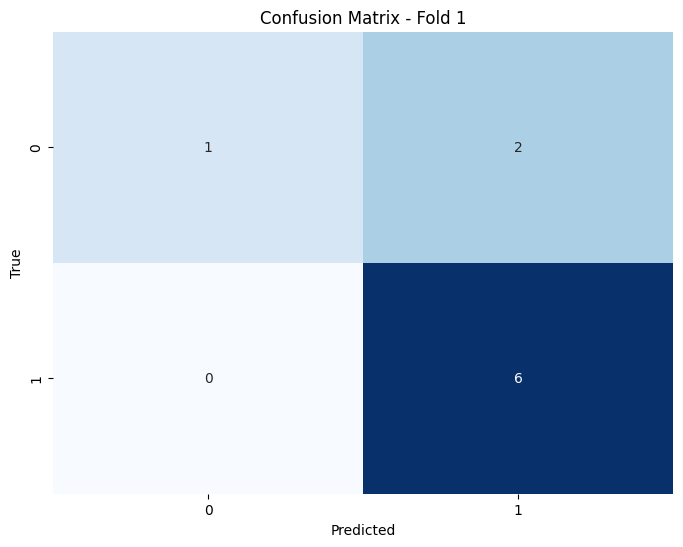

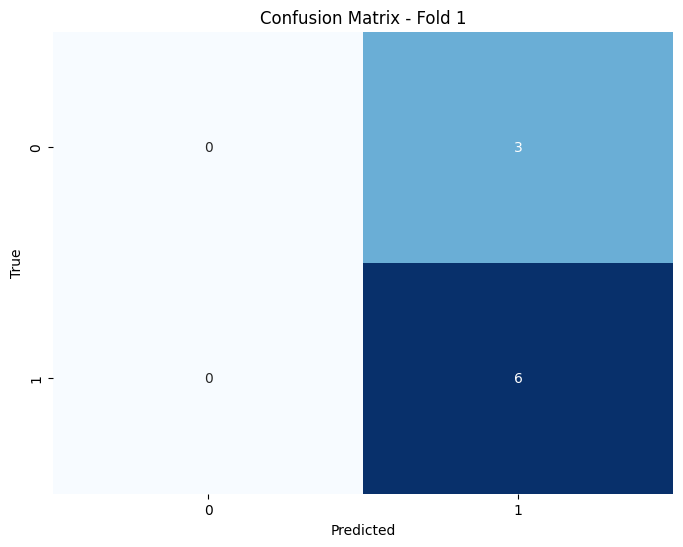


Fold 1 Test Results:
Accuracy: 0.6667
F1-Score (weighted): 0.5333
Precision: 0.6667
Recall (Sensitivity): 1.0000
MAE: 35.9122
R2: -0.7370
Best Epoch: 21

Starting Training for Fold 2
Fold 2: Train samples: 35, Val samples: 9
Class distribution - Train: [11 24], Val: [3 6]


<ipython-input-8-3051131134>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),
<ipython-input-8-3051131134>:60: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-3051131134>:546: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` bef

EarlyStopping counter: 0/10, best min: 0.1148
Epoch 1/100
Train Loss: 0.1552 (Cls: 0.0893, Reg: 0.0941)
Val Loss: 0.1148 (Cls: 0.0680, Reg: 0.0669)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 35.4978 | Val R2: -0.7221 | LR: 4.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.1148
Epoch 2/100
Train Loss: 0.1855 (Cls: 0.1141, Reg: 0.1020)
Val Loss: 0.1824 (Cls: 0.0621, Reg: 0.1718)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 30.4456 | Val R2: -0.8399 | LR: 6.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0906
Epoch 3/100
Train Loss: 0.2474 (Cls: 0.1343, Reg: 0.1615)
Val Loss: 0.0906 (Cls: 0.0551, Reg: 0.0506)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 29.3339 | Val R2: -0.2125 | LR: 7.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0906
Epoch 4/100
Train Loss: 0.2265 (Cls: 0.1261, Reg: 0.1434)
Val Loss: 0.1850 (Cls: 0.1107, Reg: 0.1062)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 25.1402 | Val R2: -0.1780 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0798
Epoch 5/100
Train Loss: 0.1518 (Cls: 0.0831, Reg: 0.0982)
Val Loss: 0.0798 (Cls: 0.0444, Reg: 0.0505)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 25.6191 | Val R2: 0.1604 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0798
Epoch 6/100
Train Loss: 0.1973 (Cls: 0.1285, Reg: 0.0982)
Val Loss: 0.1165 (Cls: 0.0670, Reg: 0.0707)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 24.0831 | Val R2: 0.1485 | LR: 9.95e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0798
Epoch 7/100
Train Loss: 0.1243 (Cls: 0.0635, Reg: 0.0869)
Val Loss: 0.2602 (Cls: 0.1167, Reg: 0.2050)
Val Acc: 0.3333 | Val F1: 0.1667 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 38.7380 | Val R2: -1.3805 | LR: 9.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0602
Epoch 8/100
Train Loss: 0.1618 (Cls: 0.0933, Reg: 0.0979)
Val Loss: 0.0602 (Cls: 0.0314, Reg: 0.0413)
Val Acc: 0.6667 | Val F1: 0.6462 | Val Precision: 0.7143 | Val Recall: 0.8333
Val MAE: 21.9954 | Val R2: 0.3585 | LR: 9.88e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0602
Epoch 9/100
Train Loss: 0.1248 (Cls: 0.0767, Reg: 0.0687)
Val Loss: 0.0808 (Cls: 0.0322, Reg: 0.0694)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 21.4203 | Val R2: 0.1024 | LR: 9.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0602
Epoch 10/100
Train Loss: 0.1198 (Cls: 0.0704, Reg: 0.0706)
Val Loss: 0.0817 (Cls: 0.0582, Reg: 0.0336)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 20.3411 | Val R2: 0.3798 | LR: 9.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0435
Epoch 11/100
Train Loss: 0.1660 (Cls: 0.1067, Reg: 0.0846)
Val Loss: 0.0435 (Cls: 0.0252, Reg: 0.0261)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 20.1451 | Val R2: 0.4157 | LR: 9.74e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0435
Epoch 12/100
Train Loss: 0.1699 (Cls: 0.0864, Reg: 0.1192)
Val Loss: 0.0659 (Cls: 0.0246, Reg: 0.0590)
Val Acc: 0.7778 | Val F1: 0.7778 | Val Precision: 0.8333 | Val Recall: 0.8333
Val MAE: 20.3395 | Val R2: 0.1344 | LR: 9.69e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0435
Epoch 13/100
Train Loss: 0.0937 (Cls: 0.0517, Reg: 0.0600)
Val Loss: 0.0459 (Cls: 0.0251, Reg: 0.0297)
Val Acc: 0.8889 | Val F1: 0.8918 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 23.3522 | Val R2: 0.3217 | LR: 9.63e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0435
Epoch 14/100
Train Loss: 0.1066 (Cls: 0.0607, Reg: 0.0655)
Val Loss: 0.0771 (Cls: 0.0216, Reg: 0.0794)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 23.9552 | Val R2: -0.0130 | LR: 9.56e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0435
Epoch 15/100
Train Loss: 0.0945 (Cls: 0.0454, Reg: 0.0701)
Val Loss: 0.1231 (Cls: 0.0216, Reg: 0.1451)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 29.1796 | Val R2: -0.6966 | LR: 9.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0435
Epoch 16/100
Train Loss: 0.0989 (Cls: 0.0545, Reg: 0.0634)
Val Loss: 0.0842 (Cls: 0.0435, Reg: 0.0582)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 25.8314 | Val R2: 0.1348 | LR: 9.42e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0435
Epoch 17/100
Train Loss: 0.1846 (Cls: 0.1370, Reg: 0.0679)
Val Loss: 0.0808 (Cls: 0.0525, Reg: 0.0404)
Val Acc: 0.5556 | Val F1: 0.5333 | Val Precision: 1.0000 | Val Recall: 0.3333
Val MAE: 22.9447 | Val R2: 0.2939 | LR: 4.67e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0435
Epoch 18/100
Train Loss: 0.1093 (Cls: 0.0468, Reg: 0.0892)
Val Loss: 0.0928 (Cls: 0.0193, Reg: 0.1050)
Val Acc: 0.8889 | Val F1: 0.8821 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 24.2594 | Val R2: -0.0732 | LR: 4.63e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0435
Epoch 19/100
Train Loss: 0.1034 (Cls: 0.0637, Reg: 0.0567)
Val Loss: 0.0950 (Cls: 0.0366, Reg: 0.0835)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 21.7522 | Val R2: 0.1620 | LR: 4.59e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0435
Epoch 20/100
Train Loss: 0.1730 (Cls: 0.1320, Reg: 0.0586)
Val Loss: 0.0480 (Cls: 0.0249, Reg: 0.0331)
Val Acc: 0.7778 | Val F1: 0.7381 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 14.9548 | Val R2: 0.6563 | LR: 4.54e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 10/10, best min: 0.0435
Early stopping triggered.

Confusion Matrix for Fold 2:


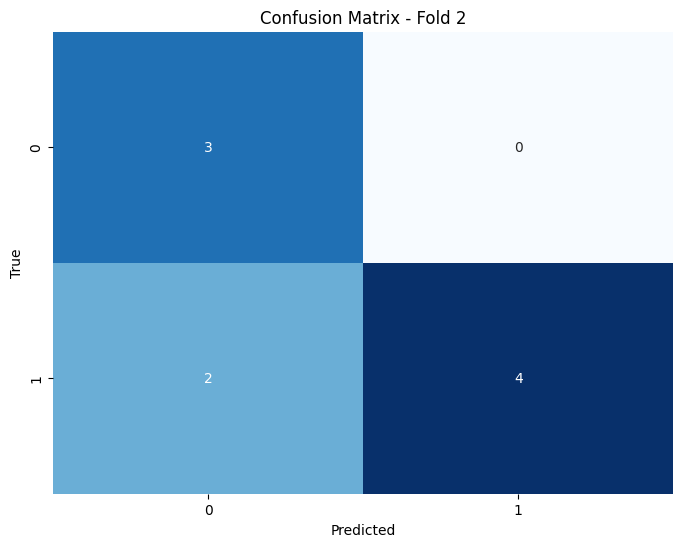

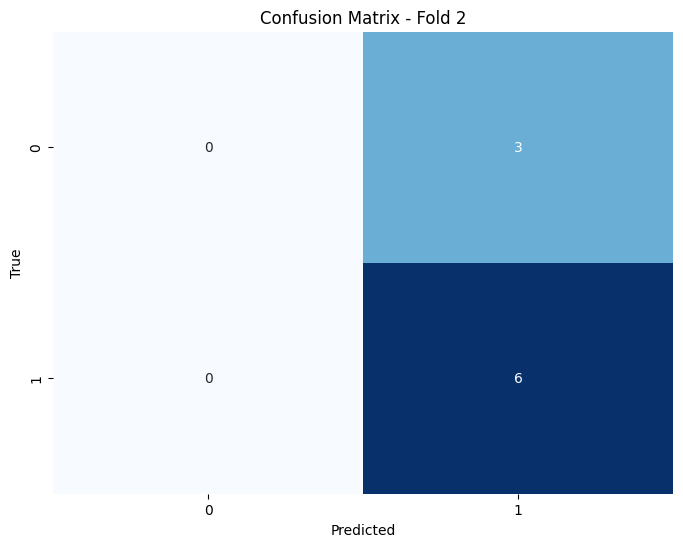


Fold 2 Test Results:
Accuracy: 0.6667
F1-Score (weighted): 0.5333
Precision: 0.6667
Recall (Sensitivity): 1.0000
MAE: 31.8971
R2: -1.1142
Best Epoch: 11

Starting Training for Fold 3
Fold 3: Train samples: 35, Val samples: 9
Class distribution - Train: [11 24], Val: [3 6]


<ipython-input-8-3051131134>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),
<ipython-input-8-3051131134>:60: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-3051131134>:546: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` bef

EarlyStopping counter: 0/10, best min: 0.2319
Epoch 1/100
Train Loss: 0.1949 (Cls: 0.1001, Reg: 0.1355)
Val Loss: 0.2319 (Cls: 0.1164, Reg: 0.1650)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 40.1440 | Val R2: -6.2518 | LR: 4.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.1185
Epoch 2/100
Train Loss: 0.1946 (Cls: 0.0795, Reg: 0.1643)
Val Loss: 0.1185 (Cls: 0.0901, Reg: 0.0406)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 27.1977 | Val R2: -3.0156 | LR: 6.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.1185
Epoch 3/100
Train Loss: 0.2186 (Cls: 0.1054, Reg: 0.1617)
Val Loss: 0.2808 (Cls: 0.1393, Reg: 0.2021)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 46.1729 | Val R2: -8.1079 | LR: 7.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0877
Epoch 4/100
Train Loss: 0.1210 (Cls: 0.0667, Reg: 0.0776)
Val Loss: 0.0877 (Cls: 0.0730, Reg: 0.0210)
Val Acc: 0.5556 | Val F1: 0.5556 | Val Precision: 0.6667 | Val Recall: 0.6667
Val MAE: 17.7136 | Val R2: -1.1025 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0877
Epoch 5/100
Train Loss: 0.2363 (Cls: 0.1342, Reg: 0.1459)
Val Loss: 0.1391 (Cls: 0.1074, Reg: 0.0453)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 20.1486 | Val R2: -0.9612 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0877
Epoch 6/100
Train Loss: 0.1461 (Cls: 0.0713, Reg: 0.1069)
Val Loss: 0.1831 (Cls: 0.0730, Reg: 0.1573)
Val Acc: 0.4444 | Val F1: 0.4589 | Val Precision: 0.6000 | Val Recall: 0.5000
Val MAE: 41.8022 | Val R2: -6.5704 | LR: 9.95e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0877
Epoch 7/100
Train Loss: 0.1667 (Cls: 0.1087, Reg: 0.0829)
Val Loss: 0.1322 (Cls: 0.0857, Reg: 0.0664)
Val Acc: 0.4444 | Val F1: 0.4103 | Val Precision: 0.5714 | Val Recall: 0.6667
Val MAE: 24.6042 | Val R2: -1.9132 | LR: 9.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0877
Epoch 8/100
Train Loss: 0.1835 (Cls: 0.0837, Reg: 0.1425)
Val Loss: 0.1451 (Cls: 0.1147, Reg: 0.0435)
Val Acc: 0.5556 | Val F1: 0.4762 | Val Precision: 0.6250 | Val Recall: 0.8333
Val MAE: 19.5424 | Val R2: -0.7397 | LR: 9.88e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0877
Epoch 9/100
Train Loss: 0.1658 (Cls: 0.0838, Reg: 0.1172)
Val Loss: 0.1236 (Cls: 0.1072, Reg: 0.0235)
Val Acc: 0.4444 | Val F1: 0.4103 | Val Precision: 0.5714 | Val Recall: 0.6667
Val MAE: 14.6895 | Val R2: 0.0462 | LR: 9.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0877
Epoch 10/100
Train Loss: 0.2112 (Cls: 0.1356, Reg: 0.1079)
Val Loss: 0.3329 (Cls: 0.2805, Reg: 0.0748)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 25.8378 | Val R2: -1.9904 | LR: 4.90e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0877
Epoch 11/100
Train Loss: 0.1271 (Cls: 0.0703, Reg: 0.0811)
Val Loss: 0.2145 (Cls: 0.1771, Reg: 0.0535)
Val Acc: 0.6667 | Val F1: 0.5333 | Val Precision: 0.6667 | Val Recall: 1.0000
Val MAE: 21.4349 | Val R2: -1.0496 | LR: 4.87e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0877
Epoch 12/100
Train Loss: 0.1278 (Cls: 0.0688, Reg: 0.0843)
Val Loss: 0.0900 (Cls: 0.0825, Reg: 0.0107)
Val Acc: 0.4444 | Val F1: 0.4589 | Val Precision: 0.6000 | Val Recall: 0.5000
Val MAE: 10.6272 | Val R2: 0.3049 | LR: 4.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0877
Epoch 13/100
Train Loss: 0.1474 (Cls: 0.0846, Reg: 0.0897)
Val Loss: 0.1415 (Cls: 0.1061, Reg: 0.0506)
Val Acc: 0.4444 | Val F1: 0.4103 | Val Precision: 0.5714 | Val Recall: 0.6667
Val MAE: 20.4775 | Val R2: -0.9182 | LR: 4.81e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 10/10, best min: 0.0877
Early stopping triggered.

Confusion Matrix for Fold 3:


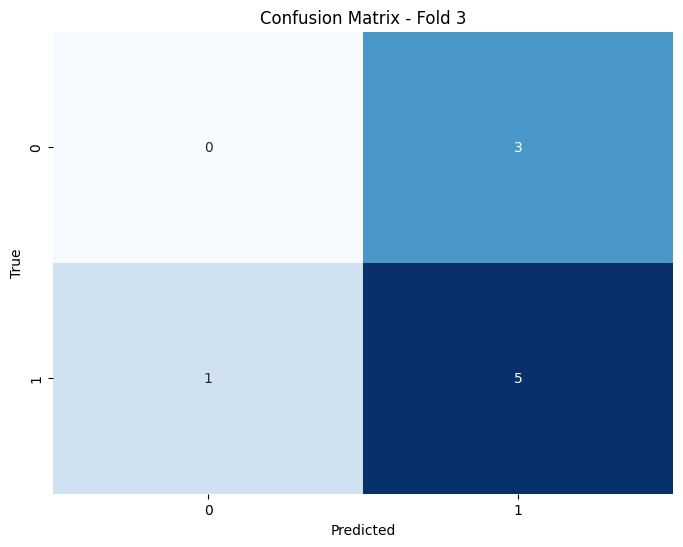

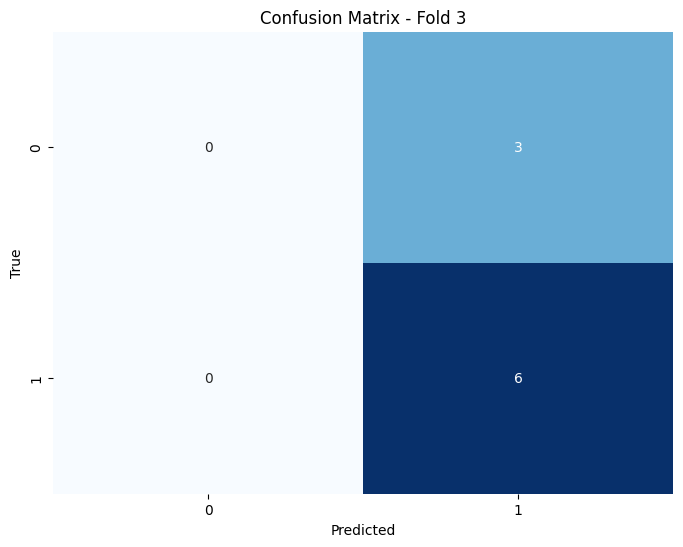


Fold 3 Test Results:
Accuracy: 0.6667
F1-Score (weighted): 0.5333
Precision: 0.6667
Recall (Sensitivity): 1.0000
MAE: 46.8250
R2: -8.3322
Best Epoch: 4

Starting Training for Fold 4
Fold 4: Train samples: 36, Val samples: 8
Class distribution - Train: [12 24], Val: [2 6]


<ipython-input-8-3051131134>:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),
<ipython-input-8-3051131134>:60: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-8-3051131134>:546: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` bef

EarlyStopping counter: 0/10, best min: 0.1006
Epoch 1/100
Train Loss: 0.3430 (Cls: 0.2445, Reg: 0.1408)
Val Loss: 0.1006 (Cls: 0.0691, Reg: 0.0449)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 23.7253 | Val R2: -0.1265 | LR: 4.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0805
Epoch 2/100
Train Loss: 0.1597 (Cls: 0.0814, Reg: 0.1119)
Val Loss: 0.0805 (Cls: 0.0550, Reg: 0.0365)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 20.7405 | Val R2: 0.0877 | LR: 6.00e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0805
Epoch 3/100
Train Loss: 0.2163 (Cls: 0.1565, Reg: 0.0854)
Val Loss: 0.1652 (Cls: 0.1409, Reg: 0.0346)
Val Acc: 0.2500 | Val F1: 0.1000 | Val Precision: 0.0000 | Val Recall: 0.0000
Val MAE: 18.8584 | Val R2: 0.1277 | LR: 7.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0755
Epoch 4/100
Train Loss: 0.2302 (Cls: 0.1564, Reg: 0.1055)
Val Loss: 0.0755 (Cls: 0.0471, Reg: 0.0406)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 21.3184 | Val R2: -0.0164 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0755
Epoch 5/100
Train Loss: 0.1521 (Cls: 0.1024, Reg: 0.0710)
Val Loss: 0.0817 (Cls: 0.0511, Reg: 0.0438)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 20.1790 | Val R2: -0.1075 | LR: 9.98e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0755
Epoch 6/100
Train Loss: 0.1542 (Cls: 0.0630, Reg: 0.1302)
Val Loss: 0.0855 (Cls: 0.0559, Reg: 0.0423)
Val Acc: 0.7500 | Val F1: 0.7667 | Val Precision: 1.0000 | Val Recall: 0.6667
Val MAE: 22.0044 | Val R2: -0.0616 | LR: 9.95e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0755
Epoch 7/100
Train Loss: 0.1191 (Cls: 0.0830, Reg: 0.0515)
Val Loss: 0.0854 (Cls: 0.0449, Reg: 0.0579)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 25.2551 | Val R2: -0.4674 | LR: 9.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0755
Epoch 8/100
Train Loss: 0.1072 (Cls: 0.0435, Reg: 0.0909)
Val Loss: 0.1183 (Cls: 0.0857, Reg: 0.0465)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 22.0990 | Val R2: -0.1768 | LR: 9.88e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0755
Epoch 9/100
Train Loss: 0.1963 (Cls: 0.1188, Reg: 0.1107)
Val Loss: 0.0985 (Cls: 0.0787, Reg: 0.0283)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 17.0953 | Val R2: 0.2907 | LR: 9.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0755
Epoch 10/100
Train Loss: 0.1306 (Cls: 0.0841, Reg: 0.0664)
Val Loss: 0.0990 (Cls: 0.0556, Reg: 0.0621)
Val Acc: 0.5000 | Val F1: 0.5333 | Val Precision: 0.7500 | Val Recall: 0.5000
Val MAE: 24.6752 | Val R2: -0.5953 | LR: 4.90e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0713
Epoch 11/100
Train Loss: 0.1167 (Cls: 0.0588, Reg: 0.0827)
Val Loss: 0.0713 (Cls: 0.0511, Reg: 0.0288)
Val Acc: 0.5000 | Val F1: 0.5333 | Val Precision: 0.7500 | Val Recall: 0.5000
Val MAE: 17.4370 | Val R2: 0.2799 | LR: 4.87e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0688
Epoch 12/100
Train Loss: 0.1069 (Cls: 0.0442, Reg: 0.0896)
Val Loss: 0.0688 (Cls: 0.0450, Reg: 0.0340)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 18.4547 | Val R2: 0.1476 | LR: 4.84e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0688
Epoch 13/100
Train Loss: 0.1031 (Cls: 0.0726, Reg: 0.0437)
Val Loss: 0.0819 (Cls: 0.0584, Reg: 0.0336)
Val Acc: 0.7500 | Val F1: 0.6429 | Val Precision: 0.7500 | Val Recall: 1.0000
Val MAE: 18.3514 | Val R2: 0.1540 | LR: 4.81e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0688
Epoch 14/100
Train Loss: 0.1107 (Cls: 0.0723, Reg: 0.0548)
Val Loss: 0.0891 (Cls: 0.0400, Reg: 0.0702)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 26.2622 | Val R2: -0.8188 | LR: 4.78e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0688
Epoch 15/100
Train Loss: 0.1505 (Cls: 0.0769, Reg: 0.1052)
Val Loss: 0.0738 (Cls: 0.0446, Reg: 0.0417)
Val Acc: 0.5000 | Val F1: 0.5333 | Val Precision: 0.7500 | Val Recall: 0.5000
Val MAE: 20.4896 | Val R2: -0.0594 | LR: 4.75e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0665
Epoch 16/100
Train Loss: 0.0725 (Cls: 0.0439, Reg: 0.0408)
Val Loss: 0.0665 (Cls: 0.0363, Reg: 0.0431)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 21.5977 | Val R2: -0.0857 | LR: 4.71e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0622
Epoch 17/100
Train Loss: 0.1083 (Cls: 0.0540, Reg: 0.0776)
Val Loss: 0.0622 (Cls: 0.0372, Reg: 0.0357)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 18.6338 | Val R2: 0.1054 | LR: 4.67e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0610
Epoch 18/100
Train Loss: 0.1235 (Cls: 0.0774, Reg: 0.0660)
Val Loss: 0.0610 (Cls: 0.0304, Reg: 0.0437)
Val Acc: 0.8750 | Val F1: 0.8590 | Val Precision: 0.8571 | Val Recall: 1.0000
Val MAE: 19.8809 | Val R2: -0.1188 | LR: 4.63e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0610
Epoch 19/100
Train Loss: 0.1077 (Cls: 0.0467, Reg: 0.0872)
Val Loss: 0.0676 (Cls: 0.0358, Reg: 0.0454)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 22.3615 | Val R2: -0.1449 | LR: 4.59e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0610
Epoch 20/100
Train Loss: 0.0739 (Cls: 0.0434, Reg: 0.0436)
Val Loss: 0.0714 (Cls: 0.0531, Reg: 0.0261)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 15.4153 | Val R2: 0.3496 | LR: 4.54e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0610
Epoch 21/100
Train Loss: 0.0716 (Cls: 0.0377, Reg: 0.0484)
Val Loss: 0.0668 (Cls: 0.0328, Reg: 0.0486)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 22.9928 | Val R2: -0.2373 | LR: 4.49e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0558
Epoch 22/100
Train Loss: 0.0985 (Cls: 0.0659, Reg: 0.0465)
Val Loss: 0.0558 (Cls: 0.0372, Reg: 0.0265)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.1809 | Val R2: 0.3378 | LR: 4.44e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0558
Epoch 23/100
Train Loss: 0.0866 (Cls: 0.0413, Reg: 0.0647)
Val Loss: 0.0638 (Cls: 0.0464, Reg: 0.0249)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 14.5248 | Val R2: 0.3808 | LR: 4.39e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0488
Epoch 24/100
Train Loss: 0.0903 (Cls: 0.0663, Reg: 0.0342)
Val Loss: 0.0488 (Cls: 0.0285, Reg: 0.0290)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 17.0134 | Val R2: 0.2702 | LR: 4.34e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0488
Epoch 25/100
Train Loss: 0.0569 (Cls: 0.0353, Reg: 0.0309)
Val Loss: 0.0513 (Cls: 0.0328, Reg: 0.0265)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.1948 | Val R2: 0.3370 | LR: 4.28e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0488
Epoch 26/100
Train Loss: 0.0689 (Cls: 0.0424, Reg: 0.0378)
Val Loss: 0.0528 (Cls: 0.0328, Reg: 0.0285)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.8103 | Val R2: 0.2831 | LR: 4.23e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0488
Epoch 27/100
Train Loss: 0.1028 (Cls: 0.0798, Reg: 0.0329)
Val Loss: 0.0550 (Cls: 0.0326, Reg: 0.0321)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 18.3529 | Val R2: 0.1922 | LR: 4.17e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0488
Epoch 28/100
Train Loss: 0.0764 (Cls: 0.0581, Reg: 0.0261)
Val Loss: 0.0574 (Cls: 0.0345, Reg: 0.0327)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.4090 | Val R2: 0.1720 | LR: 4.11e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0488
Epoch 29/100
Train Loss: 0.0813 (Cls: 0.0481, Reg: 0.0475)
Val Loss: 0.0589 (Cls: 0.0271, Reg: 0.0454)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 20.2408 | Val R2: -0.1680 | LR: 4.05e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0458
Epoch 30/100
Train Loss: 0.0699 (Cls: 0.0316, Reg: 0.0547)
Val Loss: 0.0458 (Cls: 0.0255, Reg: 0.0290)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.7255 | Val R2: 0.2689 | LR: 3.99e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0458
Epoch 31/100
Train Loss: 0.0782 (Cls: 0.0585, Reg: 0.0282)
Val Loss: 0.0568 (Cls: 0.0378, Reg: 0.0271)
Val Acc: 0.7500 | Val F1: 0.7667 | Val Precision: 1.0000 | Val Recall: 0.6667
Val MAE: 16.8582 | Val R2: 0.3232 | LR: 3.92e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0458
Epoch 32/100
Train Loss: 0.0618 (Cls: 0.0236, Reg: 0.0546)
Val Loss: 0.0542 (Cls: 0.0377, Reg: 0.0236)
Val Acc: 0.7500 | Val F1: 0.7667 | Val Precision: 1.0000 | Val Recall: 0.6667
Val MAE: 14.6715 | Val R2: 0.4086 | LR: 3.85e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0458
Epoch 33/100
Train Loss: 0.0451 (Cls: 0.0214, Reg: 0.0338)
Val Loss: 0.0699 (Cls: 0.0365, Reg: 0.0477)
Val Acc: 0.7500 | Val F1: 0.7667 | Val Precision: 1.0000 | Val Recall: 0.6667
Val MAE: 20.2316 | Val R2: -0.2295 | LR: 3.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0458
Epoch 34/100
Train Loss: 0.0823 (Cls: 0.0346, Reg: 0.0682)
Val Loss: 0.0674 (Cls: 0.0403, Reg: 0.0388)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 16.5701 | Val R2: 0.0029 | LR: 3.72e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0458
Epoch 35/100
Train Loss: 0.0435 (Cls: 0.0184, Reg: 0.0359)
Val Loss: 0.1103 (Cls: 0.0843, Reg: 0.0373)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 20.3948 | Val R2: 0.0671 | LR: 3.65e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0458
Epoch 36/100
Train Loss: 0.0762 (Cls: 0.0488, Reg: 0.0392)
Val Loss: 0.0645 (Cls: 0.0382, Reg: 0.0376)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 19.8354 | Val R2: 0.0528 | LR: 1.79e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0458
Epoch 37/100
Train Loss: 0.0469 (Cls: 0.0204, Reg: 0.0378)
Val Loss: 0.0505 (Cls: 0.0269, Reg: 0.0338)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 18.9502 | Val R2: 0.1497 | LR: 1.75e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0456
Epoch 38/100
Train Loss: 0.0658 (Cls: 0.0199, Reg: 0.0656)
Val Loss: 0.0456 (Cls: 0.0252, Reg: 0.0292)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 17.5318 | Val R2: 0.2660 | LR: 1.72e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0456
Epoch 39/100
Train Loss: 0.0511 (Cls: 0.0241, Reg: 0.0385)
Val Loss: 0.0474 (Cls: 0.0281, Reg: 0.0276)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.2451 | Val R2: 0.3021 | LR: 1.68e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0456
Epoch 40/100
Train Loss: 0.0464 (Cls: 0.0266, Reg: 0.0282)
Val Loss: 0.0576 (Cls: 0.0376, Reg: 0.0286)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 15.3512 | Val R2: 0.2714 | LR: 1.64e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0456
Epoch 41/100
Train Loss: 0.0606 (Cls: 0.0319, Reg: 0.0410)
Val Loss: 0.1046 (Cls: 0.0872, Reg: 0.0249)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 14.6661 | Val R2: 0.3713 | LR: 1.61e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0456
Epoch 42/100
Train Loss: 0.0597 (Cls: 0.0338, Reg: 0.0370)
Val Loss: 0.1176 (Cls: 0.1022, Reg: 0.0221)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 14.0070 | Val R2: 0.4457 | LR: 1.57e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0456
Epoch 43/100
Train Loss: 0.0905 (Cls: 0.0602, Reg: 0.0432)
Val Loss: 0.0973 (Cls: 0.0822, Reg: 0.0217)
Val Acc: 0.6250 | Val F1: 0.6429 | Val Precision: 1.0000 | Val Recall: 0.5000
Val MAE: 13.9880 | Val R2: 0.4576 | LR: 1.53e-06


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0456
Epoch 44/100
Train Loss: 0.0490 (Cls: 0.0257, Reg: 0.0332)
Val Loss: 0.0539 (Cls: 0.0377, Reg: 0.0233)
Val Acc: 0.7500 | Val F1: 0.7667 | Val Precision: 1.0000 | Val Recall: 0.6667
Val MAE: 15.1346 | Val R2: 0.4203 | LR: 7.45e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0439
Epoch 45/100
Train Loss: 0.0599 (Cls: 0.0353, Reg: 0.0350)
Val Loss: 0.0439 (Cls: 0.0271, Reg: 0.0240)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.5185 | Val R2: 0.4011 | LR: 7.26e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0362
Epoch 46/100
Train Loss: 0.0650 (Cls: 0.0403, Reg: 0.0353)
Val Loss: 0.0362 (Cls: 0.0192, Reg: 0.0242)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.4317 | Val R2: 0.3934 | LR: 7.06e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 0/10, best min: 0.0349
Epoch 47/100
Train Loss: 0.0440 (Cls: 0.0296, Reg: 0.0205)
Val Loss: 0.0349 (Cls: 0.0177, Reg: 0.0246)
Val Acc: 1.0000 | Val F1: 1.0000 | Val Precision: 1.0000 | Val Recall: 1.0000
Val MAE: 15.5457 | Val R2: 0.3841 | LR: 6.87e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 1/10, best min: 0.0349
Epoch 48/100
Train Loss: 0.0344 (Cls: 0.0125, Reg: 0.0313)
Val Loss: 0.0393 (Cls: 0.0217, Reg: 0.0251)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.9023 | Val R2: 0.3734 | LR: 6.67e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 2/10, best min: 0.0349
Epoch 49/100
Train Loss: 0.0413 (Cls: 0.0132, Reg: 0.0402)
Val Loss: 0.0447 (Cls: 0.0264, Reg: 0.0262)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.4699 | Val R2: 0.3445 | LR: 6.47e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 3/10, best min: 0.0349
Epoch 50/100
Train Loss: 0.0729 (Cls: 0.0438, Reg: 0.0416)
Val Loss: 0.0470 (Cls: 0.0284, Reg: 0.0266)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.5411 | Val R2: 0.3339 | LR: 6.27e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 4/10, best min: 0.0349
Epoch 51/100
Train Loss: 0.0697 (Cls: 0.0370, Reg: 0.0467)
Val Loss: 0.0485 (Cls: 0.0301, Reg: 0.0263)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.1898 | Val R2: 0.3414 | LR: 6.08e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 5/10, best min: 0.0349
Epoch 52/100
Train Loss: 0.0498 (Cls: 0.0216, Reg: 0.0402)
Val Loss: 0.0466 (Cls: 0.0283, Reg: 0.0261)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.0577 | Val R2: 0.3470 | LR: 5.88e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 6/10, best min: 0.0349
Epoch 53/100
Train Loss: 0.0402 (Cls: 0.0212, Reg: 0.0271)
Val Loss: 0.0441 (Cls: 0.0256, Reg: 0.0265)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 16.0347 | Val R2: 0.3355 | LR: 2.84e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 7/10, best min: 0.0349
Epoch 54/100
Train Loss: 0.0584 (Cls: 0.0377, Reg: 0.0296)
Val Loss: 0.0434 (Cls: 0.0243, Reg: 0.0272)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.9705 | Val R2: 0.3182 | LR: 2.74e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 8/10, best min: 0.0349
Epoch 55/100
Train Loss: 0.0496 (Cls: 0.0226, Reg: 0.0386)
Val Loss: 0.0450 (Cls: 0.0259, Reg: 0.0274)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.9522 | Val R2: 0.3126 | LR: 2.65e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 9/10, best min: 0.0349
Epoch 56/100
Train Loss: 0.0781 (Cls: 0.0572, Reg: 0.0299)
Val Loss: 0.0468 (Cls: 0.0277, Reg: 0.0273)
Val Acc: 0.8750 | Val F1: 0.8818 | Val Precision: 1.0000 | Val Recall: 0.8333
Val MAE: 15.9223 | Val R2: 0.3132 | LR: 2.55e-07


<ipython-input-8-3051131134>:566: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-3051131134>:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


EarlyStopping counter: 10/10, best min: 0.0349
Early stopping triggered.

Confusion Matrix for Fold 4:


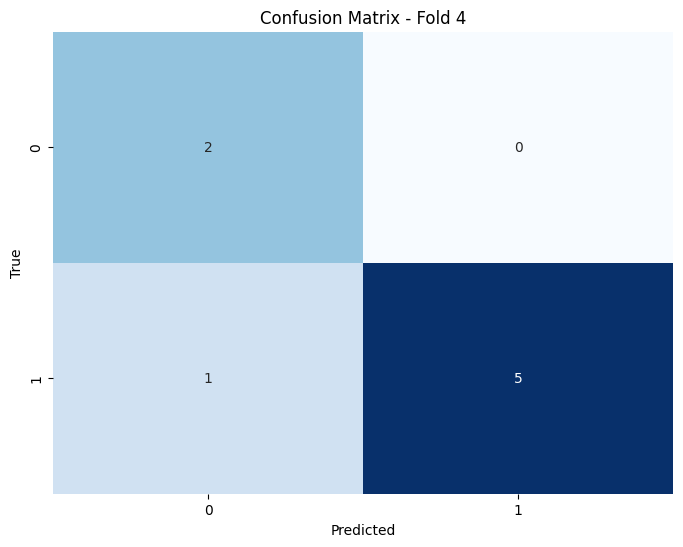

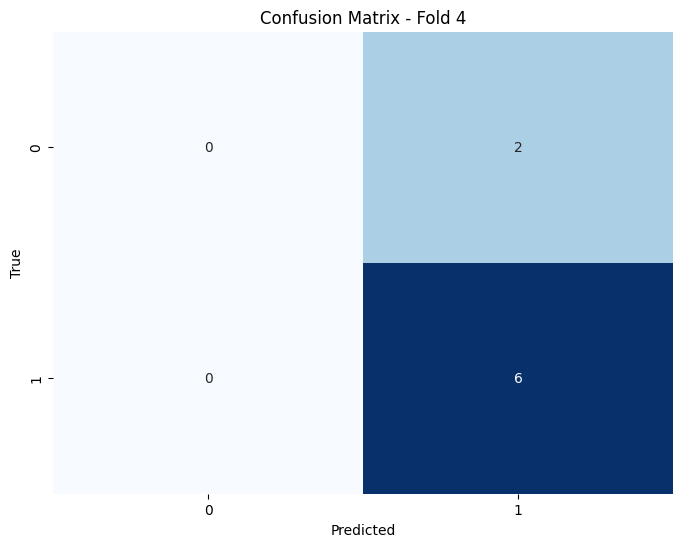


Fold 4 Test Results:
Accuracy: 0.7500
F1-Score (weighted): 0.6429
Precision: 0.7500
Recall (Sensitivity): 1.0000
MAE: 39.1711
R2: -2.5654
Best Epoch: 47

Best Classification Model: Fold 4
  Accuracy: 0.7500
  F1 Binary: 0.8571
  Classification Score: 0.6964

Best Regression Model: Fold 0
  MAE: 27.5678
Loaded classification head from results_20250614_170825/best_model_fold_4.pth
Loaded regression head from results_20250614_170825/best_model_fold_0.pth

Saved best overall model with classification head from fold 4 and regression head from fold 0

Final Test Results on Held-Out Test Set:
Accuracy: 0.7273
F1-Score (weighted): 0.6124
Precision: 0.7273
Recall (Sensitivity): 1.0000
MAE: 32.7454
R2: -1.0589


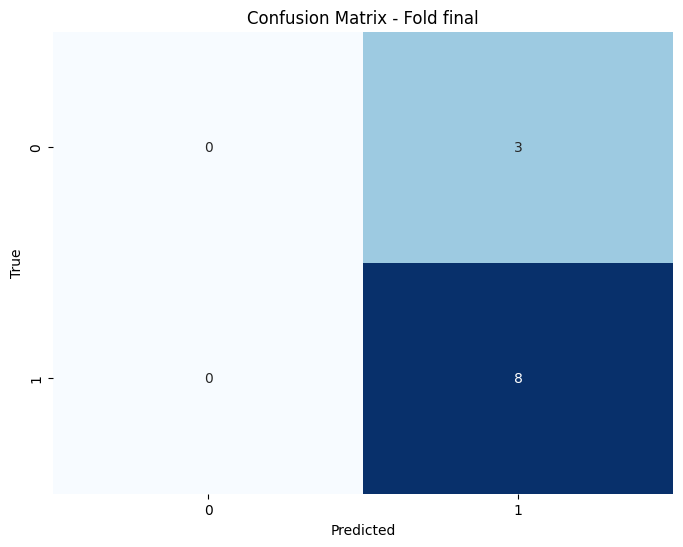


Optimal Classification Threshold: 0.4635

Performing inference on test sample 1:


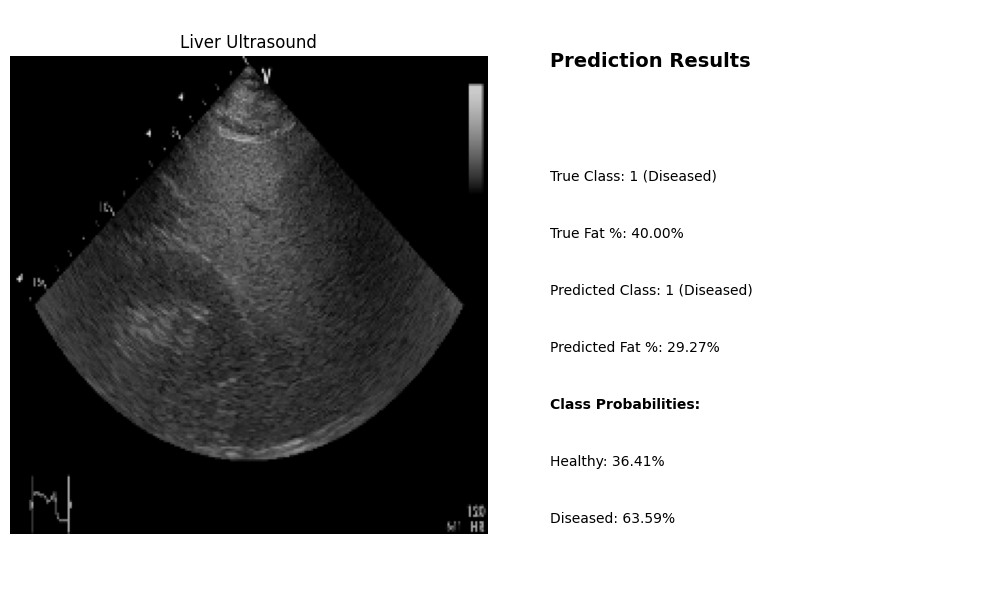


Inference Results:
True Class: 1 (Diseased)
True Fat Percentage: 40.00%
Predicted Class: 1 (Diseased)
Predicted Fat Percentage: 29.27%
Class Probabilities: Healthy=36.41%, Diseased=63.59%

Performing inference on test sample 5:


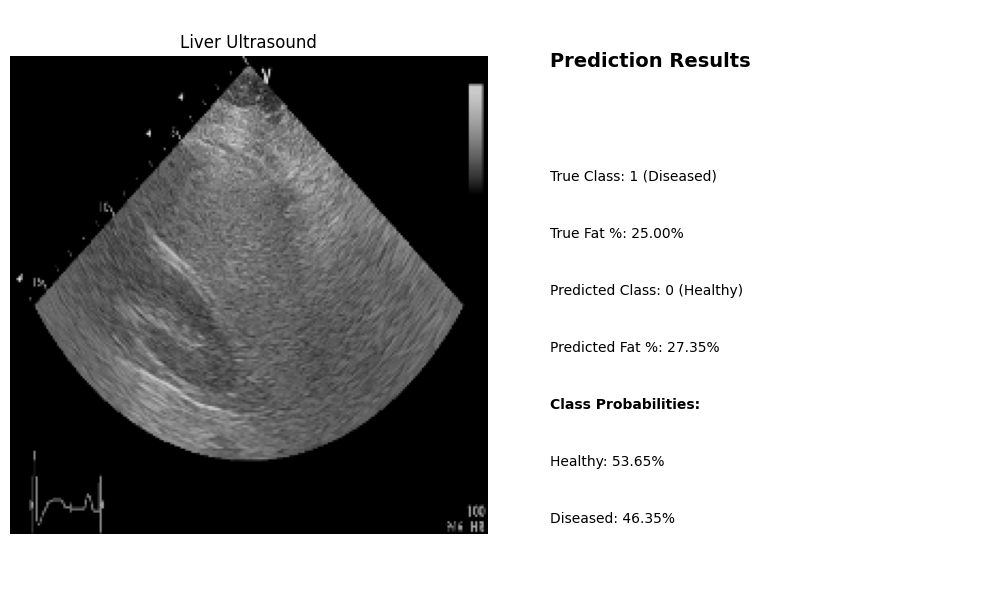


Inference Results:
True Class: 1 (Diseased)
True Fat Percentage: 25.00%
Predicted Class: 0 (Healthy)
Predicted Fat Percentage: 27.35%
Class Probabilities: Healthy=53.65%, Diseased=46.35%

Performing inference on test sample 8:


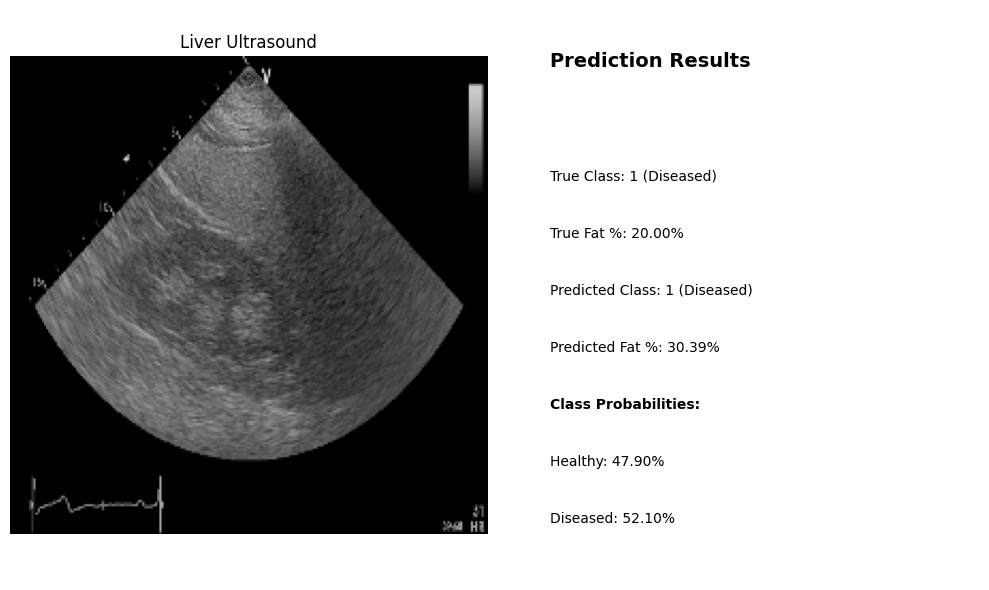


Inference Results:
True Class: 1 (Diseased)
True Fat Percentage: 20.00%
Predicted Class: 1 (Diseased)
Predicted Fat Percentage: 30.39%
Class Probabilities: Healthy=47.90%, Diseased=52.10%

Cross-Validation Summary:
        metric       mean       std        min        max
0     Accuracy   0.683333  0.037268   0.666667   0.750000
1  F1-Weighted   0.555238  0.048981   0.533333   0.642857
2    F1-Binary   0.811429  0.025555   0.800000   0.857143
3    Precision   0.683333  0.037268   0.666667   0.750000
4       Recall   1.000000  0.000000   1.000000   1.000000
5          MAE  36.274628  7.328070  27.567766  46.824966
6           R2  -2.638600  3.285459  -8.332164  -0.444257

All results saved to: results_20250614_170825


In [8]:

# ========================================================================
# Data Scaling and Splitting
# ========================================================================

class FatScaler:
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.range = max_val - min_val

    def scale(self, fat):
        return (fat - self.min) / self.range

    def descale(self, scaled):
        return scaled * self.range + self.min

# Create scaler based on full dataset
fat_scaler = FatScaler(fat_min, fat_max)
scaled_fats = fat_scaler.scale(all_fats)

# Split data into train+val (80%) and test (20%)
train_val_idx, test_idx = train_test_split(
    np.arange(len(all_classes)),
    test_size=0.2,
    stratify=all_classes,
    random_state=42
)

train_val_vols = all_vols[train_val_idx]
train_val_classes = all_classes[train_val_idx]
train_val_fats = scaled_fats[train_val_idx]  # Use scaled fats

test_vols = all_vols[test_idx]
test_classes = all_classes[test_idx]
test_fats = scaled_fats[test_idx]  # Use scaled fats

# ========================================================================
# Dataset and Transformation
# ========================================================================

def create_transforms(img_size=224):
    train_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.OneOf([
            A.HorizontalFlip(p=0.7),
            A.VerticalFlip(p=0.3),
            A.Rotate(limit=25, p=0.5),
        ], p=0.8),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
            A.RandomGamma(gamma_limit=(80, 120), p=0.2),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0)),
            A.GaussianBlur(blur_limit=(3, 7)),
            A.MedianBlur(blur_limit=3),
            A.MotionBlur(blur_limit=7),
        ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.4),
        A.RandomGridShuffle(grid=(3, 3), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    eval_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    tta_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, eval_transform, tta_transform

class AdvancedLiverDataset(Dataset):
    def __init__(self, volumes, classes, fats, transform=None, is_train=False):
        self.vols = volumes
        self.classes = classes
        self.fats = fats
        self.transform = transform
        self.is_train = is_train
        self.class_weights = self._calculate_class_weights()
        self.sample_weights = self._calculate_sample_weights()

    def _calculate_class_weights(self):
        class_counts = np.bincount(self.classes)
        beta = 0.999999  # More aggressive for severe imbalance
        effective_num = 1.0 - np.power(beta, class_counts)
        weights = (1.0 - beta) / np.maximum(effective_num, 1e-4)

        # Apply sqrt smoothing
        weights = np.sqrt(weights)

        # Normalize weights
        return weights / weights.sum() * len(weights)

    def _calculate_sample_weights(self):
        sample_weights = [self.class_weights[cls] for cls in self.classes]
        return sample_weights

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        vol = self.vols[idx]

        # For training, randomly select a slice; for eval, use middle slice
        if self.is_train and vol.ndim == 3:
            slice_idx = np.random.randint(0, vol.shape[0])
            img2d = vol[slice_idx]
        else:
            mid = vol.shape[0] // 2
            img2d = vol[mid] if vol.ndim == 3 else vol

        img2d_3channel = np.stack([img2d] * 3, axis=-1)
        if img2d_3channel.dtype != np.uint8:
            if img2d_3channel.dtype == np.uint16:
                img2d_3channel = (img2d_3channel / np.max(img2d_3channel) * 255).astype(np.uint8)
            else:
                img2d_3channel = (img2d_3channel - np.min(img2d_3channel)) / (np.max(img2d_3channel) - np.min(img2d_3channel)) * 255
                img2d_3channel = img2d_3channel.astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=img2d_3channel)
            img = augmented['image']
        else:
            img = transforms.ToTensor()(img2d_3channel)

        return img, self.classes[idx], self.fats[idx]

# ========================================================================
# Model Definition
# ========================================================================

class HybridSteatosisModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=True,
                 cls_head_path=None, reg_head_path=None,
                 drop_rate=0.2, drop_path_rate=0.1,
                 class_counts=None):
        super().__init__()

        # Use Vision Transformer as backbone
        self.backbone = timm.create_model(
            'vit_small_patch16_224',
            pretrained=pretrained,
            num_classes=0,  # Return all tokens
            global_pool=''  # Disable global pooling
        )
        in_features = self.backbone.embed_dim  # Embedding dimension (384)

        # Store class counts for bias initialization
        self.class_counts = class_counts

        # Add attention pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        # Classification Head with balanced initialization
        self.cls_head = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Dropout(drop_rate),
            nn.Linear(in_features, 512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes, bias=False)  # No bias in last layer
        )

        # Regression Head with improved initialization
        self.reg_head = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Dropout(drop_rate),
            nn.Linear(in_features, 512),
            nn.SiLU(),  # Swish activation
            nn.Dropout(drop_rate),
            nn.Linear(512, 512),
            nn.SiLU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, 1)
        )

        # Stochastic depth
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

        # Initialize model with class-balanced settings
        self._init_weights()

        # Load heads if paths are provided
        if cls_head_path:
            self._load_head(cls_head_path, 'cls')
        if reg_head_path:
            self._load_head(reg_head_path, 'reg')

    def _init_weights(self):
        # Initialize attention pooling
        for layer in self.attention_pool:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        # Initialize classification head with balanced initialization
        for i, layer in enumerate(self.cls_head):
            if isinstance(layer, nn.Linear):
                # Kaiming initialization with ReLU nonlinearity
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

                # Initialize last layer with small values
                if i == len(self.cls_head) - 1:
                    stdv = 1. / math.sqrt(layer.weight.size(1))
                    nn.init.uniform_(layer.weight, -stdv, stdv)

        # Initialize regression head with small values
        for layer in self.reg_head:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='linear')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

        # Initialize final classification bias based on class imbalance
        if self.class_counts is not None:
            total = sum(self.class_counts)
            class_ratios = [count / total for count in self.class_counts]
            bias_init = torch.log(torch.tensor([class_ratios[1] / class_ratios[0]]))
            # Manually add bias to the last layer
            self.cls_head[-1].bias = nn.Parameter(bias_init)
            self.cls_head[-1].bias.requires_grad = True

    def _load_head(self, path, head_type):
        """Load specific head weights from a saved model"""
        if not os.path.exists(path):
            raise FileNotFoundError(f"Head weights not found at {path}")

        state_dict = torch.load(path, map_location='cpu')
        head_keys = [k for k in state_dict.keys() if k.startswith(f'{head_type}_head')]

        if not head_keys:
            raise ValueError(f"No {head_type} head weights found in {path}")

        head_state_dict = {k.replace(f'{head_type}_head.', ''): state_dict[k] for k in head_keys}

        if head_type == 'cls':
            self.cls_head.load_state_dict(head_state_dict)
            print(f"Loaded classification head from {path}")
        else:
            self.reg_head.load_state_dict(head_state_dict)
            print(f"Loaded regression head from {path}")

    def forward(self, x):
        # Get all tokens from backbone [batch_size, num_tokens, embed_dim]
        tokens = self.backbone(x)  # Shape: [B, 197, 384]

        # Attention pooling - apply attention to each token
        attn_weights = self.attention_pool(tokens)  # Shape: [B, 197, 1]

        # Weighted sum of tokens
        features = torch.sum(tokens * attn_weights, dim=1)  # Shape: [B, 384]

        # Apply stochastic depth
        features = self.drop_path(features)

        # Pass features to heads
        cls_output = self.cls_head(features)
        reg_output = self.reg_head(features).squeeze()

        return cls_output, reg_output

# ========================================================================
# Loss Functions
# ========================================================================

class BalancedFocalLoss(_Loss):
    def __init__(self, alpha=0.8, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, class_weights=None):
        # Convert class weights to tensor if provided
        if class_weights is not None:
            class_weights = class_weights.to(inputs.device)

        # Calculate focal loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        # Apply class weights if provided
        if class_weights is not None:
            weights = class_weights[targets]
            focal_loss = focal_loss * weights

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

class LogCoshLoss(_Loss):
    """Log-Cosh loss that is smoother than Huber and L2"""
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        error = inputs - targets
        loss = torch.log(torch.cosh(error + 1e-12))

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# ========================================================================
# Training Utilities
# ========================================================================

class EarlyStopping:
    def __init__(self, patience=10, mode='min', min_delta=0, verbose=True):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_metric = None
        self.early_stop = False

    def __call__(self, current_metric):
        if self.best_metric is None:
            self.best_metric = current_metric
        elif self.mode == 'min':
            if current_metric < self.best_metric - self.min_delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
        elif self.mode == 'max':
            if current_metric > self.best_metric + self.min_delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1

        if self.verbose:
            print(f'EarlyStopping counter: {self.counter}/{self.patience}, best {self.mode}: {self.best_metric:.4f}')

        if self.counter >= self.patience:
            self.early_stop = True

def save_confusion_matrix(cm, classes, fold, results_dir, display=True):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.savefig(os.path.join(results_dir, f'fold_{fold}_confusion_matrix.png'))

    if display:
        plt.show()
    else:
        plt.close()

    # Save as CSV
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    cm_df.to_csv(os.path.join(results_dir, f'fold_{fold}_confusion_matrix.csv'), index=True)

# ========================================================================
# Evaluation Functions
# ========================================================================

def evaluate(model, loader, device, fat_scaler, tta_transforms=None, num_tta=5):
    model.eval()
    cls_preds = []
    cls_true = []
    reg_preds = []
    reg_true = []

    with torch.no_grad():
        for images, cls_labels, reg_labels in loader:
            images = images.to(device)
            cls_labels = cls_labels.cpu().numpy()
            reg_labels = reg_labels.cpu().numpy()

            # Standard evaluation
            cls_out, reg_out = model(images)

            # Test-time augmentation
            if tta_transforms and num_tta > 0:
                tta_cls_preds = []
                tta_reg_preds = []

                for _ in range(num_tta):
                    # Apply TTA transformations
                    augmented_images = []
                    for img in images.cpu().numpy():
                        # Convert tensor to numpy image (H, W, C)
                        img_np = img.transpose(1, 2, 0)
                        augmented = tta_transforms(image=img_np)['image']
                        augmented_images.append(augmented)

                    augmented_images = torch.stack(augmented_images).to(device)

                    # Forward pass with augmented images
                    cls_out_tta, reg_out_tta = model(augmented_images)
                    tta_cls_preds.append(torch.softmax(cls_out_tta, dim=1).cpu().numpy())
                    tta_reg_preds.append(reg_out_tta.cpu().numpy())

                # Average TTA predictions
                cls_out = torch.tensor(np.mean(tta_cls_preds, axis=0)).to(device)
                reg_out = torch.tensor(np.mean(tta_reg_preds, axis=0)).to(device)

            # Handle classification predictions
            cls_pred = torch.argmax(cls_out, dim=1)
            cls_preds.extend(cls_pred.cpu().numpy())
            cls_true.extend(cls_labels)

            # Handle regression predictions
            reg_out = reg_out.cpu().numpy()
            if reg_out.ndim == 0:  # Handle scalar output
                reg_out = np.array([reg_out])
            reg_preds.extend(reg_out)
            reg_true.extend(reg_labels)

    # Classification metrics
    acc = accuracy_score(cls_true, cls_preds)
    f1_weighted = f1_score(cls_true, cls_preds, average='weighted', zero_division=0)
    f1_binary = f1_score(cls_true, cls_preds, average='binary', zero_division=0)
    precision = precision_score(cls_true, cls_preds, zero_division=0)
    recall = recall_score(cls_true, cls_preds, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(cls_true, cls_preds)


    # Descale regression predictions
    reg_true_descaled = fat_scaler.descale(np.array(reg_true))
    reg_preds_descaled = fat_scaler.descale(np.array(reg_preds))

    # Regression metrics
    mae = mean_absolute_error(reg_true_descaled, reg_preds_descaled)
    r2 = r2_score(reg_true_descaled, reg_preds_descaled)

    metrics = {
        'acc': acc,
        'f1_weighted': f1_weighted,
        'f1_binary': f1_binary,
        'precision': precision,
        'recall': recall,
        'mae': mae,
        'r2': r2
    }

    return metrics, cm, cls_preds, reg_preds_descaled

def find_optimal_threshold(model, val_loader, device):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad():
        for images, cls_labels, _ in val_loader:
            images = images.to(device)
            cls_out, _ = model(images)
            probs.append(torch.softmax(cls_out, dim=1)[:, 1].cpu().numpy())
            labels.append(cls_labels.numpy())

    probs = np.concatenate(probs)
    labels = np.concatenate(labels)

    fpr, tpr, thresholds = roc_curve(labels, probs)
    # Find threshold that maximizes true positive rate - false positive rate
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

# ========================================================================
# Training Function
# ========================================================================

def train_model(model, train_loader, val_loader, device, fat_scaler, num_epochs=50, fold=0):
    # Get class weights for balanced loss
    class_weights = torch.tensor(train_loader.dataset.class_weights, dtype=torch.float).to(device)

    # Get class counts for bias initialization
    class_counts = np.bincount(train_loader.dataset.classes)
    model.class_counts = class_counts

    # Loss functions
    cls_criterion = BalancedFocalLoss(alpha=0.8, gamma=3.0)  # Higher gamma for hard examples
    reg_criterion = LogCoshLoss()  # Smoother than Huber

    # Create parameter groups with different learning rates
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if 'backbone' in name:
            backbone_params.append(param)
        else:
            head_params.append(param)

    optimizer = optim.AdamW(
        [
            {'params': backbone_params, 'lr': 1e-5},
            {'params': head_params, 'lr': 3e-4}
        ],
        weight_decay=1e-4
    )

    # Schedulers
    scheduler_cosine = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Early stopping
    early_stopping = EarlyStopping(patience=10, mode='min', verbose=True)

    # Warmup scheduler
    warmup_epochs = 5
    warmup_scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: min(1.0, (epoch + 1) / warmup_epochs)
    )

    best_val_loss = float('inf')
    history = []
    best_metrics = {}

    # Mixed precision training
    scaler = GradScaler()

    for epoch in range(num_epochs):
        # Warmup phase
        if epoch < warmup_epochs:
            warmup_scheduler.step()

        model.train()
        running_loss = 0.0
        cls_running_loss = 0.0
        reg_running_loss = 0.0

        for images, cls_labels, reg_labels in train_loader:
            images = images.to(device)
            cls_labels = cls_labels.to(device)
            reg_labels = reg_labels.to(device).float()

            optimizer.zero_grad()

            # Mixed precision context
            with autocast():
                cls_out, reg_out = model(images)
                cls_loss = cls_criterion(cls_out, cls_labels, class_weights)
                reg_loss = reg_criterion(reg_out, reg_labels)
                total_loss = cls_loss + 0.7 * reg_loss  # Weighted sum

            # Backward pass with scaling
            scaler.scale(total_loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            scaler.step(optimizer)
            scaler.update()

            running_loss += total_loss.item()
            cls_running_loss += cls_loss.item()
            reg_running_loss += reg_loss.item()

        # Calculate validation loss
        model.eval()
        val_running_loss = 0.0
        val_cls_running_loss = 0.0
        val_reg_running_loss = 0.0

        with torch.no_grad(), autocast():
            for images, cls_labels, reg_labels in val_loader:
                images = images.to(device)
                cls_labels = cls_labels.to(device)
                reg_labels = reg_labels.to(device).float()

                cls_out, reg_out = model(images)
                cls_loss = cls_criterion(cls_out, cls_labels, class_weights)
                reg_loss = reg_criterion(reg_out, reg_labels)
                total_val_loss = cls_loss + 0.7 * reg_loss

                val_running_loss += total_val_loss.item()
                val_cls_running_loss += cls_loss.item()
                val_reg_running_loss += reg_loss.item()

        # Calculate average validation loss
        val_loss = val_running_loss / len(val_loader)
        val_cls_loss = val_cls_running_loss / len(val_loader)
        val_reg_loss = val_reg_running_loss / len(val_loader)

        # Get validation metrics
        val_metrics, val_cm, _, _ = evaluate(model, val_loader, device, fat_scaler)
        val_acc = val_metrics['acc']
        val_f1_weighted = val_metrics['f1_weighted']
        val_f1_binary = val_metrics['f1_binary']
        val_precision = val_metrics['precision']
        val_recall = val_metrics['recall']
        val_mae = val_metrics['mae']
        val_r2 = val_metrics['r2']

        # Step schedulers
        scheduler_cosine.step()
        scheduler_plateau.step(val_loss)

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(results_dir, f'best_model_fold_{fold}.pth'))
            best_metrics = {
                'epoch': epoch+1,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_f1_weighted': val_f1_weighted,
                'val_f1_binary': val_f1_binary,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_mae': val_mae,
                'val_r2': val_r2
            }

        epoch_metrics = {
            'fold': fold,
            'epoch': epoch+1,
            'train_loss': running_loss/len(train_loader),
            'cls_loss': cls_running_loss/len(train_loader),
            'reg_loss': reg_running_loss/len(train_loader),
            'val_loss': val_loss,
            'val_cls_loss': val_cls_loss,
            'val_reg_loss': val_reg_loss,
            'val_acc': val_acc,
            'val_f1_weighted': val_f1_weighted,
            'val_f1_binary': val_f1_binary,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'lr': optimizer.param_groups[0]['lr']  # Head learning rate
        }
        history.append(epoch_metrics)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_metrics['train_loss']:.4f} (Cls: {epoch_metrics['cls_loss']:.4f}, Reg: {epoch_metrics['reg_loss']:.4f})")
        print(f"Val Loss: {val_loss:.4f} (Cls: {val_cls_loss:.4f}, Reg: {val_reg_loss:.4f})")
        print(f"Val Acc: {val_acc:.4f} | Val F1: {val_f1_weighted:.4f} | Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")
        print(f"Val MAE: {val_mae:.4f} | Val R2: {val_r2:.4f} | LR: {epoch_metrics['lr']:.2e}")

    # Save training history for this fold
    history_df = pd.DataFrame(history)
    history_df.to_csv(os.path.join(results_dir, f'fold_{fold}_training_history.csv'), index=False)

    # Display confusion matrix for best epoch
    print(f"\nConfusion Matrix for Fold {fold}:")
    save_confusion_matrix(val_cm, classes=[0, 1], fold=fold, results_dir=results_dir, display=True)

    return history, best_metrics

# ========================================================================
# Data Loading
# ========================================================================

def prepare_loaders(fold=0, img_size=224, batch_size=8):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_transform, eval_transform, tta_transform = create_transforms(img_size)

    splits = list(skf.split(train_val_vols, train_val_classes))
    if fold >= skf.n_splits:
        raise ValueError(f"Fold index {fold} out of bounds for {skf.n_splits} splits.")

    train_idx, val_idx = splits[fold]

    train_vols = train_val_vols[train_idx]
    train_classes = train_val_classes[train_idx]
    train_fats = train_val_fats[train_idx]

    val_vols = train_val_vols[val_idx]
    val_classes = train_val_classes[val_idx]
    val_fats = train_val_fats[val_idx]

    train_ds = AdvancedLiverDataset(train_vols, train_classes, train_fats, train_transform, is_train=True)
    val_ds = AdvancedLiverDataset(val_vols, val_classes, val_fats, eval_transform)

    # Create balanced sampler
    sample_weights = train_ds.sample_weights
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Fold {fold}: Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")
    print(f"Class distribution - Train: {np.bincount(train_classes)}, Val: {np.bincount(val_classes)}")

    return train_loader, val_loader, tta_transform

# ========================================================================
# Model Selection and Inference
# ========================================================================

def select_best_models(all_folds_test_metrics):
    # Create DataFrame from metrics
    metrics_df = pd.DataFrame(all_folds_test_metrics)

    # Find best classification model
    metrics_df['cls_score'] = (metrics_df['test_acc'] + metrics_df['test_f1_weighted']) / 2
    best_cls_fold = metrics_df['cls_score'].idxmax()
    best_cls_model_path = os.path.join(results_dir, f'best_model_fold_{best_cls_fold}.pth')

    # Find best regression model
    best_reg_fold = metrics_df['test_mae'].idxmin()
    best_reg_model_path = os.path.join(results_dir, f'best_model_fold_{best_reg_fold}.pth')

    print(f"\nBest Classification Model: Fold {best_cls_fold}")
    print(f"  Accuracy: {metrics_df.loc[best_cls_fold, 'test_acc']:.4f}")
    print(f"  F1 Binary: {metrics_df.loc[best_cls_fold, 'test_f1_binary']:.4f}")
    print(f"  Classification Score: {metrics_df.loc[best_cls_fold, 'cls_score']:.4f}")

    print(f"\nBest Regression Model: Fold {best_reg_fold}")
    print(f"  MAE: {metrics_df.loc[best_reg_fold, 'test_mae']:.4f}")

    return best_cls_model_path, best_reg_model_path, best_cls_fold, best_reg_fold

def inference(model, sample, device, fat_scaler, results_dir, sample_idx=0):
    model.eval()
    image, true_class, true_fat = sample

    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        cls_out, reg_out = model(image)
        cls_probs = torch.softmax(cls_out, dim=1)
        pred_class = torch.argmax(cls_out, dim=1).item()
        pred_fat = reg_out.item()

    # Descale fat percentages
    true_fat_percent = fat_scaler.descale(true_fat)
    pred_fat_percent = fat_scaler.descale(pred_fat)

    # Convert to disease status
    class_labels = {0: "Healthy", 1: "Diseased"}
    true_class_label = class_labels.get(true_class, "Unknown")
    pred_class_label = class_labels.get(pred_class, "Unknown")

    # Create visualization
    plt.figure(figsize=(10, 6))

    # Display image
    plt.subplot(1, 2, 1)
    img_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.title(f"Liver Ultrasound")
    plt.axis('off')

    # Display prediction results
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, "Prediction Results", fontsize=14, fontweight='bold')
    plt.text(0.1, 0.7, f"True Class: {true_class} ({true_class_label})")
    plt.text(0.1, 0.6, f"True Fat %: {true_fat_percent:.2f}%")
    plt.text(0.1, 0.5, f"Predicted Class: {pred_class} ({pred_class_label})")
    plt.text(0.1, 0.4, f"Predicted Fat %: {pred_fat_percent:.2f}%")
    plt.text(0.1, 0.3, "Class Probabilities:", fontweight='bold')
    plt.text(0.1, 0.2, f"Healthy: {cls_probs[0][0].item()*100:.2f}%")
    plt.text(0.1, 0.1, f"Diseased: {cls_probs[0][1].item()*100:.2f}%")

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'inference_sample_{sample_idx}.png'))
    plt.show()

    print("\n" + "="*50)
    print("Inference Results:")
    print("="*50)
    print(f"True Class: {true_class} ({true_class_label})")
    print(f"True Fat Percentage: {true_fat_percent:.2f}%")
    print(f"Predicted Class: {pred_class} ({pred_class_label})")
    print(f"Predicted Fat Percentage: {pred_fat_percent:.2f}%")
    print(f"Class Probabilities: Healthy={cls_probs[0][0].item()*100:.2f}%, Diseased={cls_probs[0][1].item()*100:.2f}%")
    print("="*50)

    return pred_class, pred_fat_percent

# ========================================================================
# Main Training Execution
# ========================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize metrics collection
all_folds_history = []
all_folds_best_metrics = []
all_folds_test_metrics = []

# Create test dataset
_, eval_transform, tta_transform = create_transforms()
test_ds = AdvancedLiverDataset(test_vols, test_classes, test_fats, eval_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Run K-Fold Cross-Validation on train_val set
for fold in range(5):
    print(f"\n{'='*50}")
    print(f"Starting Training for Fold {fold}")
    print(f"{'='*50}")

    # Create fresh model for each fold
    model = HybridSteatosisModel().to(device)
    train_loader, val_loader, tta_transform = prepare_loaders(fold=fold, img_size=224, batch_size=8)

    # Train model and record history
    fold_history, fold_best_metrics = train_model(
        model,
        train_loader,
        val_loader,
        device,
        fat_scaler,
        num_epochs=100,  # Increased epochs with early stopping
        fold=fold
    )
    all_folds_history.append(fold_history)

    # Evaluate best model with TTA
    best_model = HybridSteatosisModel().to(device)
    best_model.load_state_dict(torch.load(os.path.join(results_dir, f'best_model_fold_{fold}.pth')))
    test_metrics, test_cm, cls_preds, reg_preds = evaluate(
        best_model,
        val_loader,
        device,
        fat_scaler,
        tta_transforms=tta_transform,
        num_tta=5
    )

    # Save confusion matrix
    save_confusion_matrix(test_cm, classes=[0, 1], fold=fold, results_dir=results_dir, display=True)

    fold_test_metrics = {
        'fold': fold,
        'test_acc': test_metrics['acc'],
        'test_f1_weighted': test_metrics['f1_weighted'],
        'test_f1_binary': test_metrics['f1_binary'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_mae': test_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'best_epoch': fold_best_metrics['epoch']
    }
    all_folds_test_metrics.append(fold_test_metrics)

    print(f"\nFold {fold} Test Results:")
    print(f"Accuracy: {test_metrics['acc']:.4f}")
    print(f"F1-Score (weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall (Sensitivity): {test_metrics['recall']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"R2: {test_metrics['r2']:.4f}")
    print(f"Best Epoch: {fold_best_metrics['epoch']}")

    # Save fold metrics to CSV
    pd.DataFrame([fold_test_metrics]).to_csv(os.path.join(results_dir, f'fold_{fold}_test_metrics.csv'), index=False)

# Create best overall model
best_cls_path, best_reg_path, best_cls_fold, best_reg_fold = select_best_models(all_folds_test_metrics)
best_overall_model = HybridSteatosisModel(
    cls_head_path=best_cls_path,
    reg_head_path=best_reg_path
).to(device)

# Save best overall model
torch.save(best_overall_model.state_dict(), os.path.join(results_dir, 'best_overall_model.pth'))
print(f"\nSaved best overall model with classification head from fold {best_cls_fold} and regression head from fold {best_reg_fold}")

# Evaluate best overall model on test set with TTA
test_metrics, test_cm, _, _ = evaluate(
    best_overall_model,
    test_loader,
    device,
    fat_scaler,
    tta_transforms=tta_transform,
    num_tta=5
)

print("\n" + "="*50)
print("Final Test Results on Held-Out Test Set:")
print("="*50)
print(f"Accuracy: {test_metrics['acc']:.4f}")
print(f"F1-Score (weighted): {test_metrics['f1_weighted']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall (Sensitivity): {test_metrics['recall']:.4f}")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"R2: {test_metrics['r2']:.4f}")

# Save final test metrics
final_metrics = {
    'test_acc': test_metrics['acc'],
    'test_f1_weighted': test_metrics['f1_weighted'],
    'test_f1_binary': test_metrics['f1_binary'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_mae': test_metrics['mae'],
    'test_r2': test_metrics['r2'],
    'cls_head_from': best_cls_fold,
    'reg_head_from': best_reg_fold
}
pd.DataFrame([final_metrics]).to_csv(os.path.join(results_dir, 'final_test_metrics.csv'), index=False)

# Save confusion matrix for test set
save_confusion_matrix(test_cm, classes=[0, 1], fold='final', results_dir=results_dir, display=True)

# Find optimal threshold for classification
optimal_threshold = find_optimal_threshold(best_overall_model, test_loader, device)
print(f"\nOptimal Classification Threshold: {optimal_threshold:.4f}")

# Perform inference on 3 random test samples
for i in range(3):
    random_idx = np.random.randint(0, len(test_ds))
    sample = test_ds[random_idx]
    print(f"\nPerforming inference on test sample {random_idx}:")
    pred_class, pred_fat = inference(best_overall_model, sample, device, fat_scaler, results_dir, sample_idx=i)

# Calculate and save average metrics
test_metrics_df = pd.DataFrame(all_folds_test_metrics)
summary_metrics = {
    'metric': ['Accuracy', 'F1-Weighted', 'F1-Binary', 'Precision', 'Recall', 'MAE', 'R2'],
    'mean': [
        test_metrics_df['test_acc'].mean(),
        test_metrics_df['test_f1_weighted'].mean(),
        test_metrics_df['test_f1_binary'].mean(),
        test_metrics_df['test_precision'].mean(),
        test_metrics_df['test_recall'].mean(),
        test_metrics_df['test_mae'].mean(),
        test_metrics_df['test_r2'].mean()
    ],
    'std': [
        test_metrics_df['test_acc'].std(),
        test_metrics_df['test_f1_weighted'].std(),
        test_metrics_df['test_f1_binary'].std(),
        test_metrics_df['test_precision'].std(),
        test_metrics_df['test_recall'].std(),
        test_metrics_df['test_mae'].std(),
        test_metrics_df['test_r2'].std()
    ],
    'min': [
        test_metrics_df['test_acc'].min(),
        test_metrics_df['test_f1_weighted'].min(),
        test_metrics_df['test_f1_binary'].min(),
        test_metrics_df['test_precision'].min(),
        test_metrics_df['test_recall'].min(),
        test_metrics_df['test_mae'].min(),
        test_metrics_df['test_r2'].min()
    ],
    'max': [
        test_metrics_df['test_acc'].max(),
        test_metrics_df['test_f1_weighted'].max(),
        test_metrics_df['test_f1_binary'].max(),
        test_metrics_df['test_precision'].max(),
        test_metrics_df['test_recall'].max(),
        test_metrics_df['test_mae'].max(),
        test_metrics_df['test_r2'].max()
    ]
}

summary_df = pd.DataFrame(summary_metrics)
summary_df.to_csv(os.path.join(results_dir, 'cross_validation_summary.csv'), index=False)

print("\nCross-Validation Summary:")
print(summary_df)

# Save all test metrics
test_metrics_df.to_csv(os.path.join(results_dir, 'all_folds_test_metrics.csv'), index=False)

print(f"\nAll results saved to: {results_dir}")